<a href="https://colab.research.google.com/github/EmiMontalto/Analisis-V1/blob/main/IA_transformer_compra_venta_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00


In [ ]:
from google.colab import  drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import json

In [ ]:

def detect_and_plot_peaks(data):
    # Detectar picos alcistas
    bullish_peaks, _ = find_peaks(data['Close'], distance=10, prominence=1)

    # Detectar picos bajistas (invertimos la serie para encontrar mínimos como máximos)
    bearish_peaks, _ = find_peaks(-data['Close'], distance=10, prominence=1)

    # Inicializar columna 'Peak_Type' con valores 'None'
    data['Peak_Type'] = 'None'

    # Asignar valores 'Bullish' y 'Bearish' basados en índices numéricos
    data.iloc[bullish_peaks, data.columns.get_loc('Peak_Type')] = 'Bullish'
    data.iloc[bearish_peaks, data.columns.get_loc('Peak_Type')] = 'Bearish'

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Close'].iloc[bullish_peaks], 'o', color='green', label='Bullish Peaks')
    plt.plot(data['Close'].iloc[bearish_peaks], 'o', color='red', label='Bearish Peaks')
    plt.title('Price and Peaks')
    plt.legend()
    plt.show()

    return data

def label_data_for_long_strategy(data):
    # Inicializar una nueva columna con valores 'None'
    data['Trade_Signal'] = 'None'
    # Inicializar una nueva columna para representar numéricamente las señales de trading
    data['Numeric_Signal'] = 0

    current_signal = 'venta'  # Inicialmente asumimos que estamos en posición de venta
    numeric_signal = -1

    for i in range(len(data)):
        if data.iloc[i]['Peak_Type'] == 'Bearish':
            current_signal = 'compra'
            numeric_signal = 1
        elif data.iloc[i]['Peak_Type'] == 'Bullish':
            current_signal = 'venta'
            numeric_signal = -1

        data.iloc[i, data.columns.get_loc('Trade_Signal')] = current_signal
        data.iloc[i, data.columns.get_loc('Numeric_Signal')] = numeric_signal

    # Contar las señales numéricas positivas y negativas
    positive_signals = (data['Numeric_Signal'] == 1).sum()
    negative_signals = (data['Numeric_Signal'] == -1).sum()

    print(f"Señales numéricas positivas: {positive_signals}")
    print(f"Señales numéricas negativas: {negative_signals}")

    # Verificar si la suma de ambas cantidades corresponde con el índice final
    if positive_signals + negative_signals != len(data):
        mismatched_indices = data[data['Numeric_Signal'] == 0].index.tolist()
        print(f"Las velas que no corresponden son: {mismatched_indices}")
    else:
        print("La suma de señales positivas y negativas corresponde con el índice final.")

    return data



[*********************100%%**********************]  1 of 1 completed


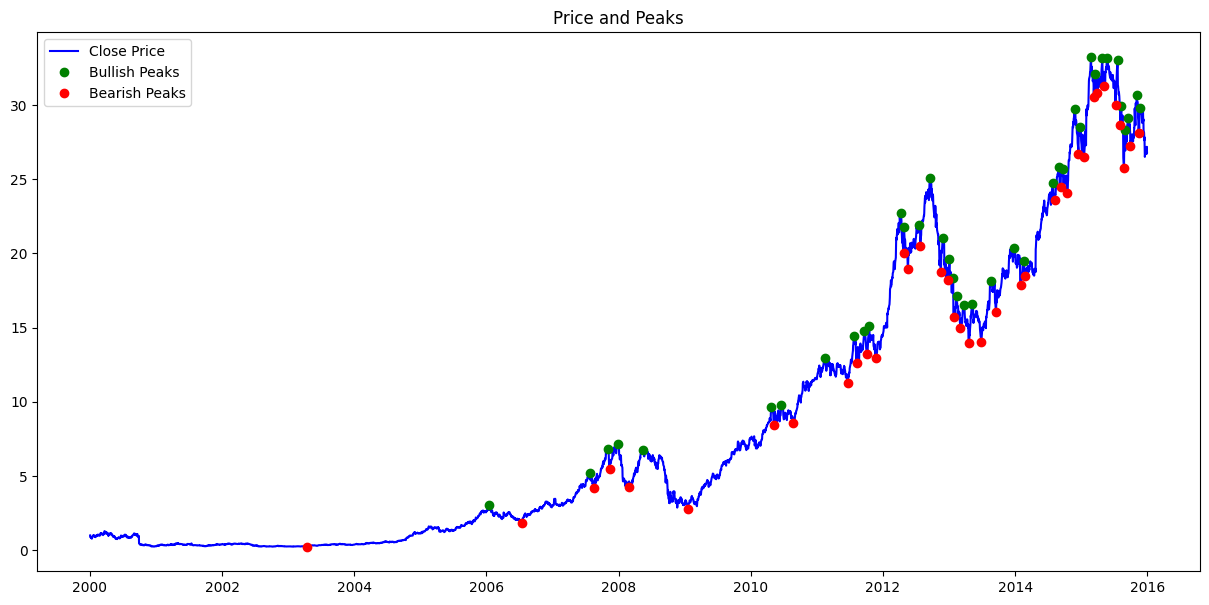

Señales numéricas positivas: 2234
Señales numéricas negativas: 1790
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


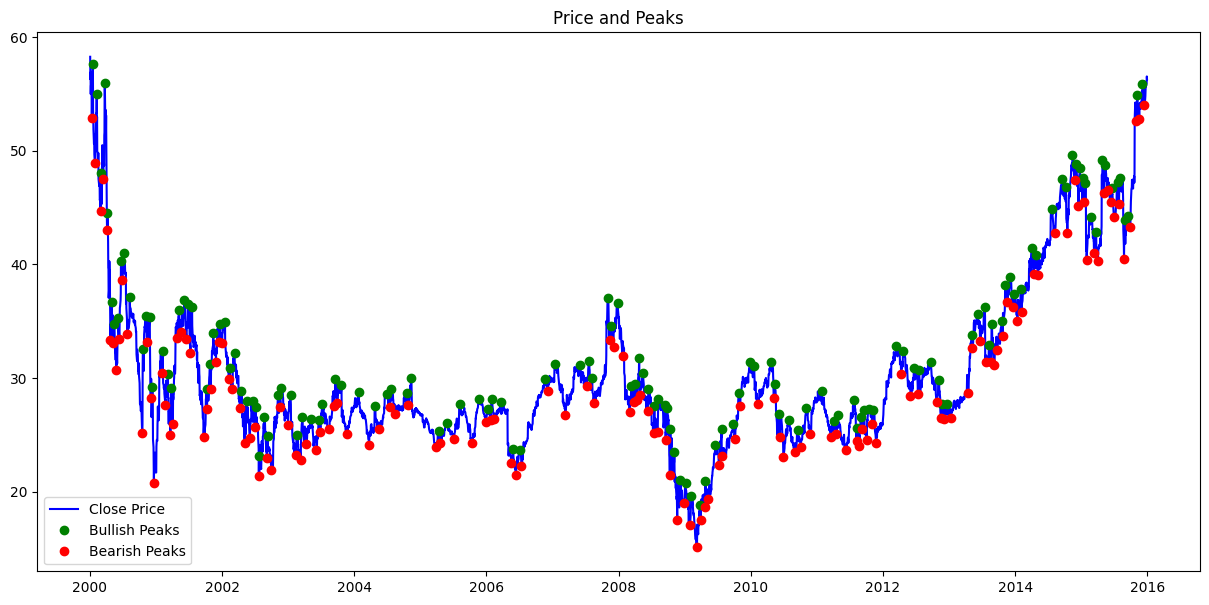

Señales numéricas positivas: 2112
Señales numéricas negativas: 1912
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


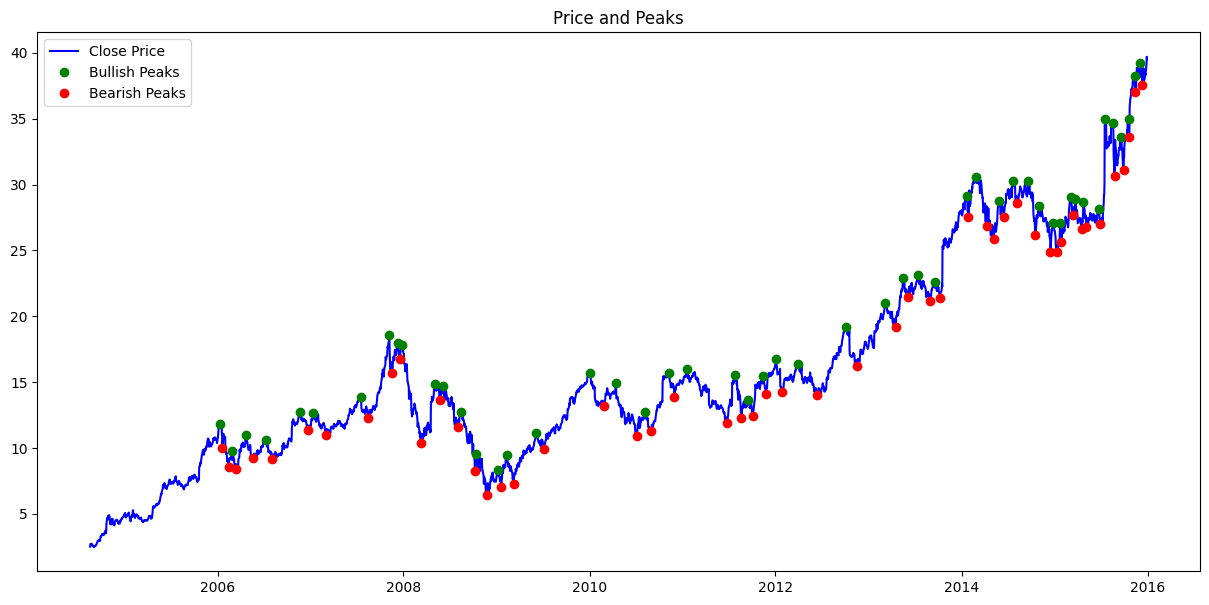

Señales numéricas positivas: 1477
Señales numéricas negativas: 1385
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


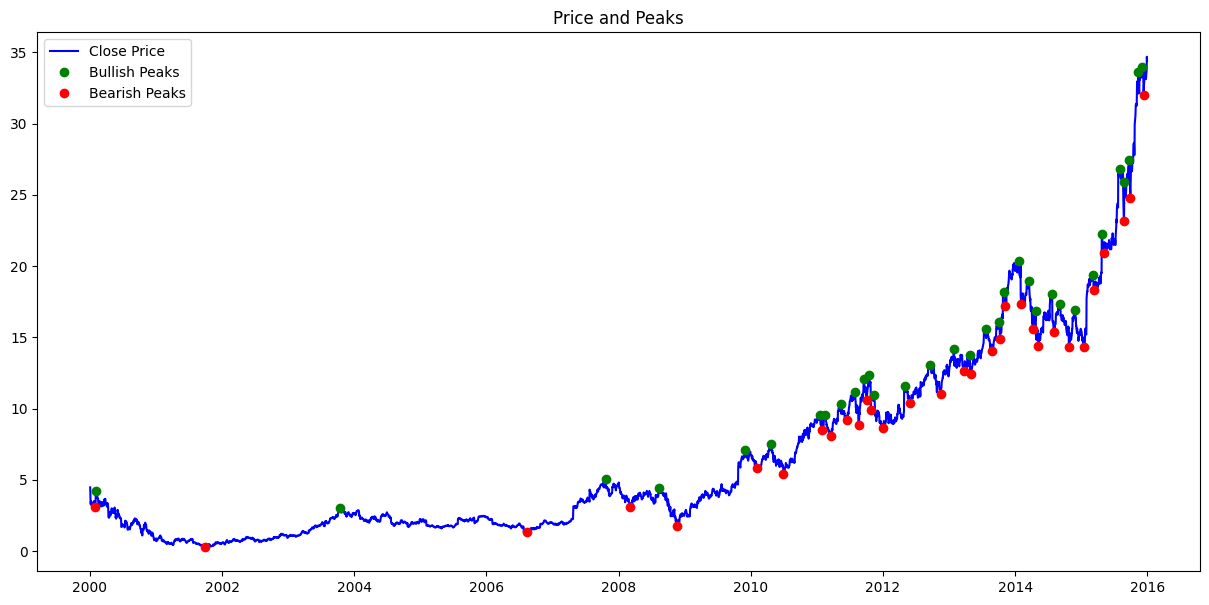

Señales numéricas positivas: 2193
Señales numéricas negativas: 1831
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


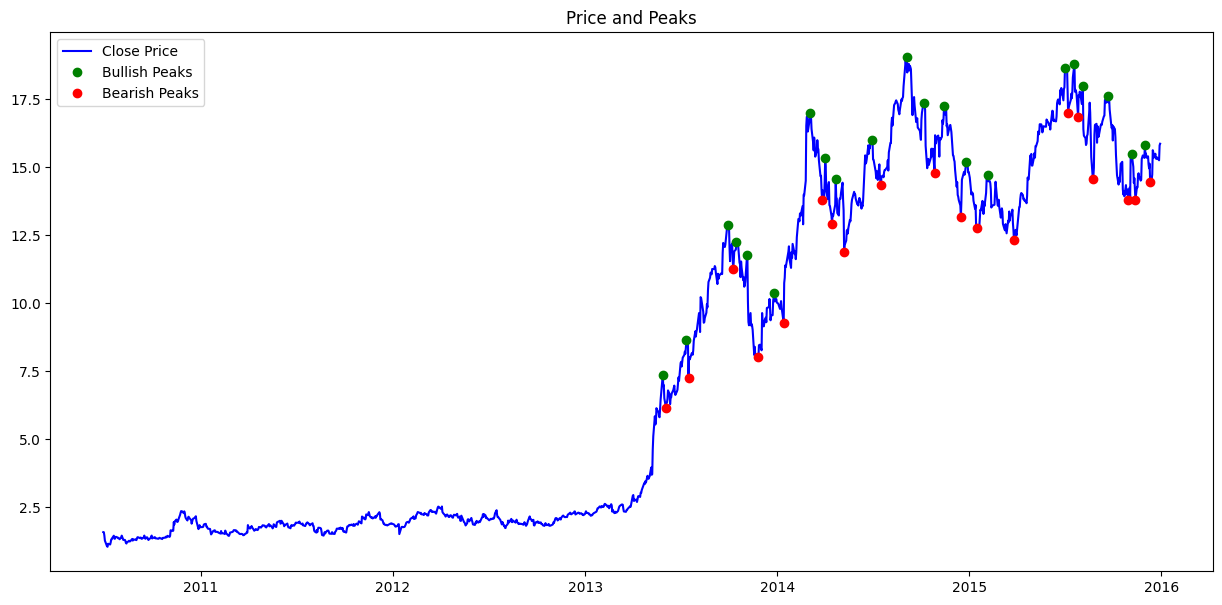

Señales numéricas positivas: 382
Señales numéricas negativas: 1005
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


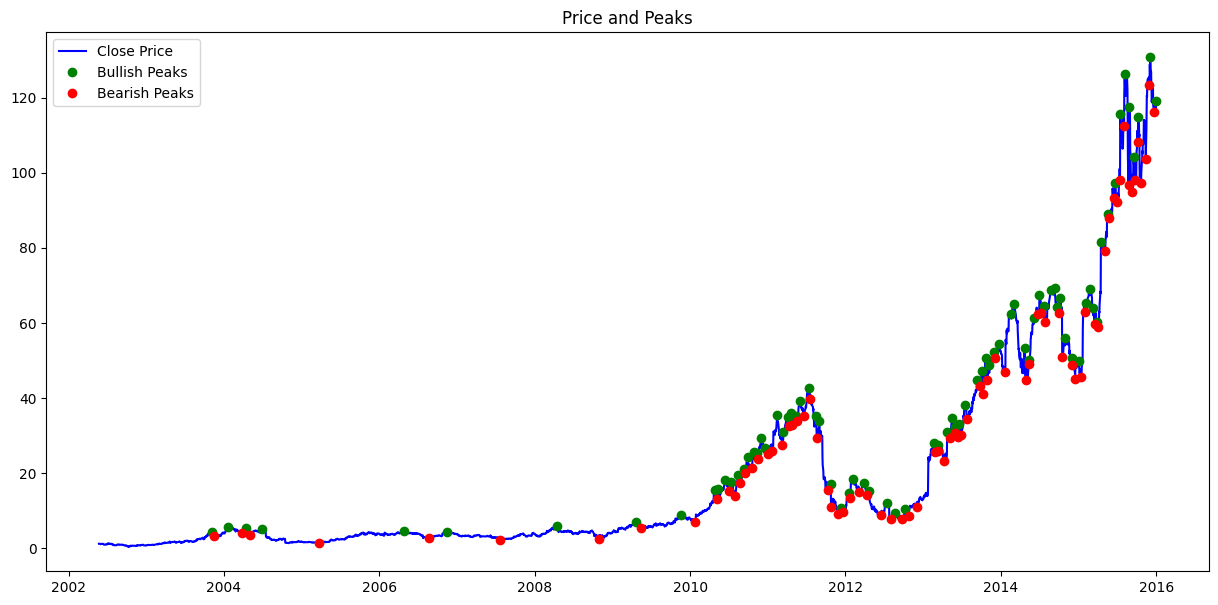

Señales numéricas positivas: 1662
Señales numéricas negativas: 1764
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


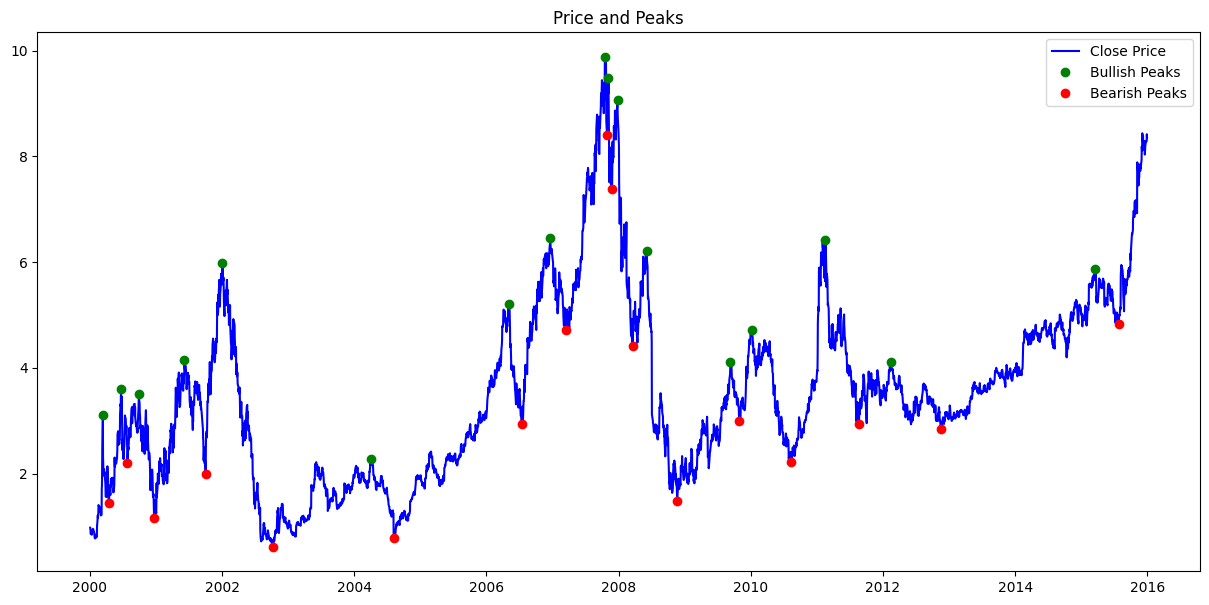

Señales numéricas positivas: 2621
Señales numéricas negativas: 1403
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


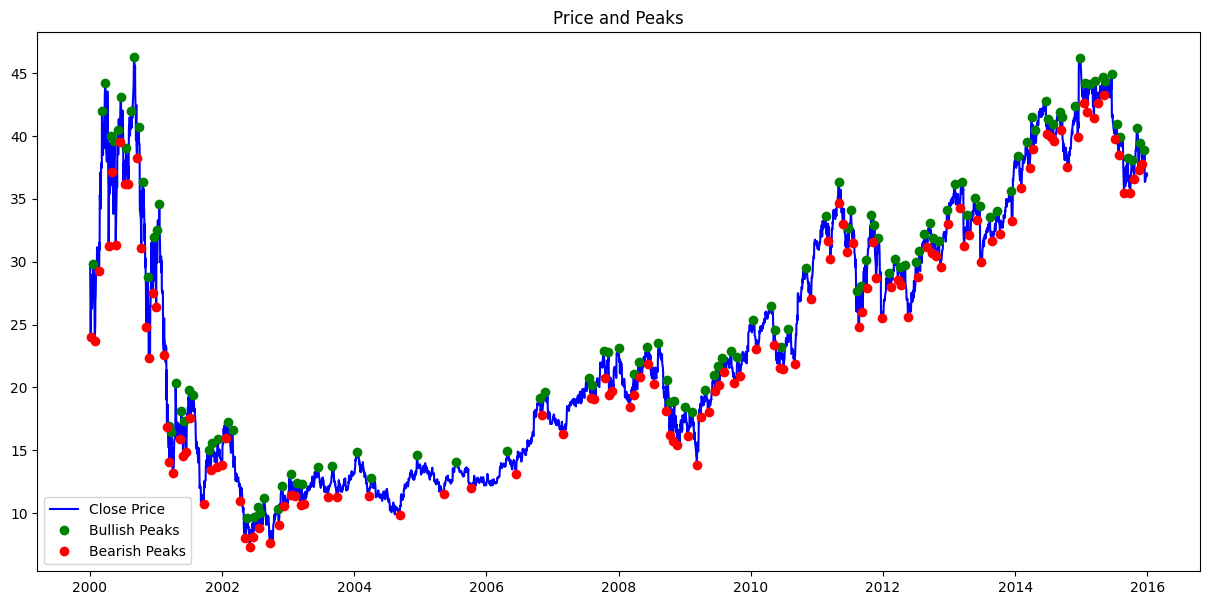

Señales numéricas positivas: 2296
Señales numéricas negativas: 1728
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


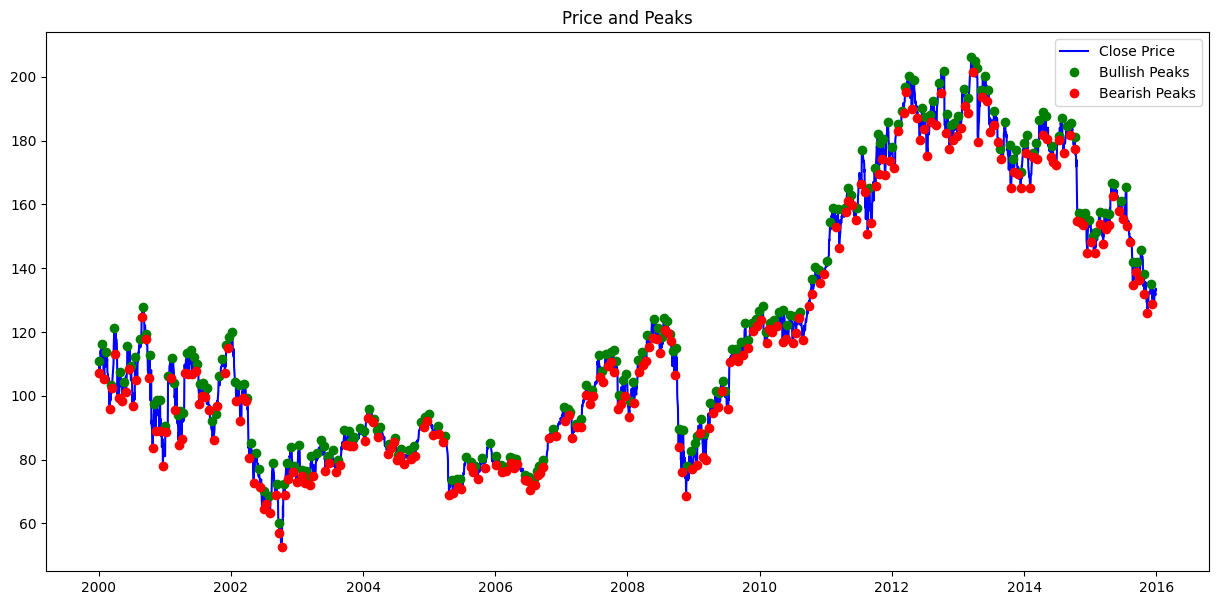

Señales numéricas positivas: 2095
Señales numéricas negativas: 1929
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


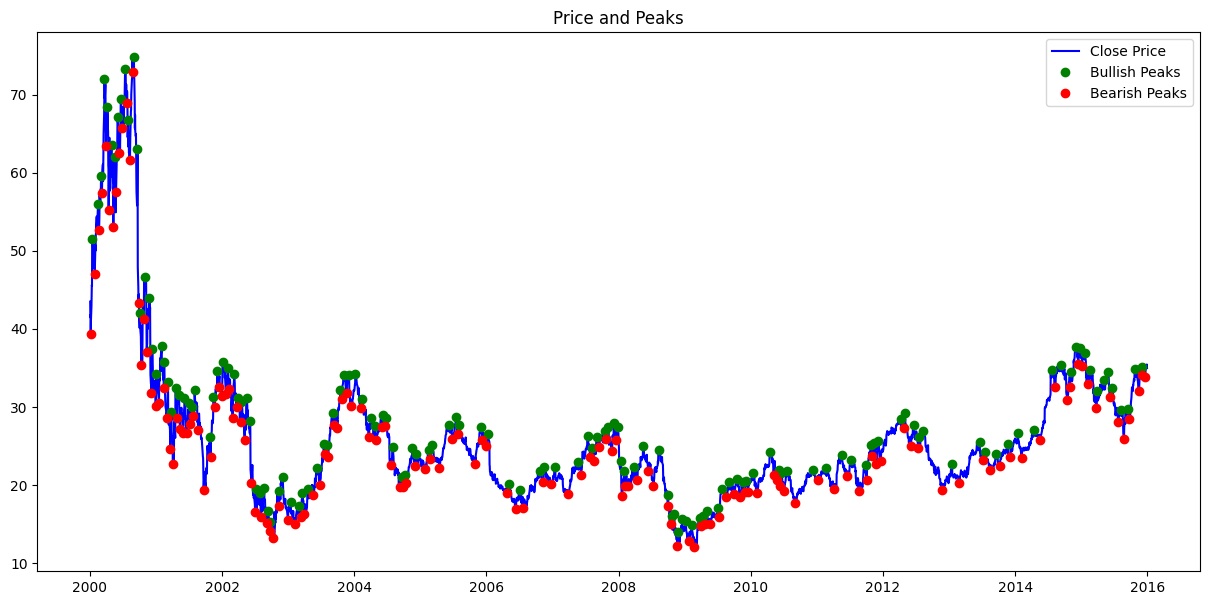

Señales numéricas positivas: 2116
Señales numéricas negativas: 1908
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


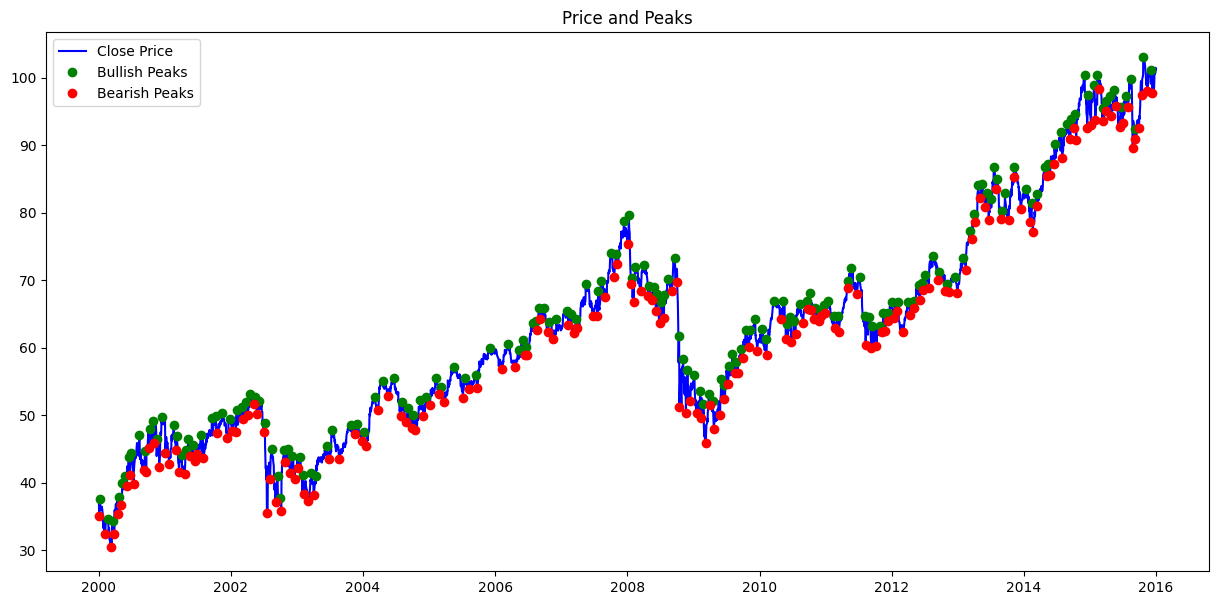

Señales numéricas positivas: 2112
Señales numéricas negativas: 1912
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


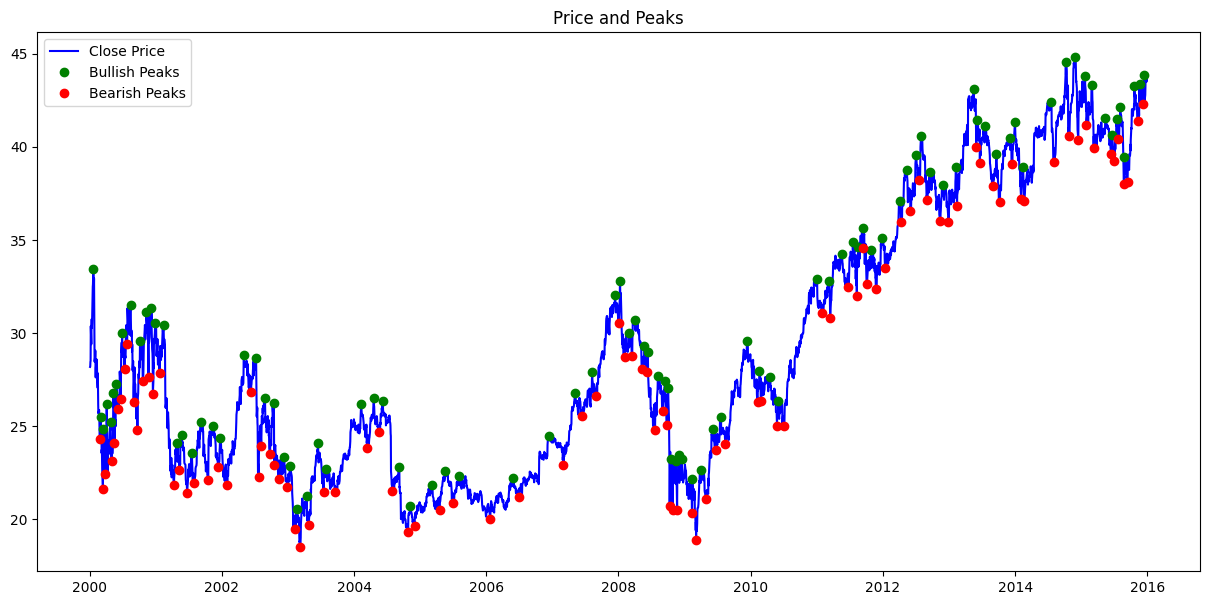

Señales numéricas positivas: 2306
Señales numéricas negativas: 1718
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


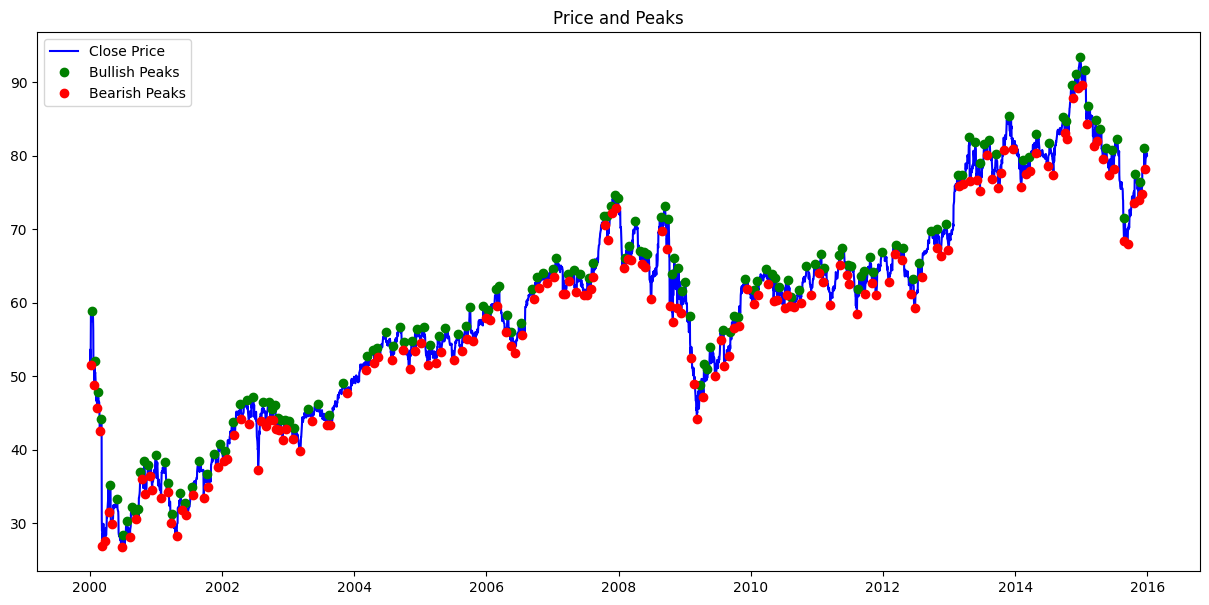

Señales numéricas positivas: 2228
Señales numéricas negativas: 1796
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


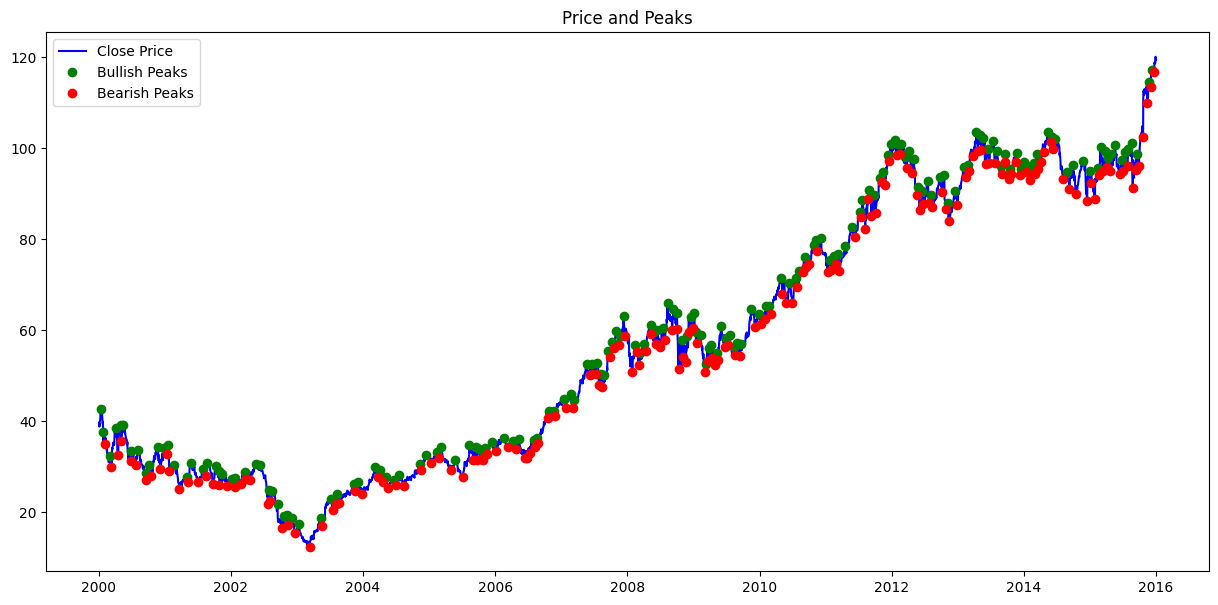

Señales numéricas positivas: 2194
Señales numéricas negativas: 1830
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


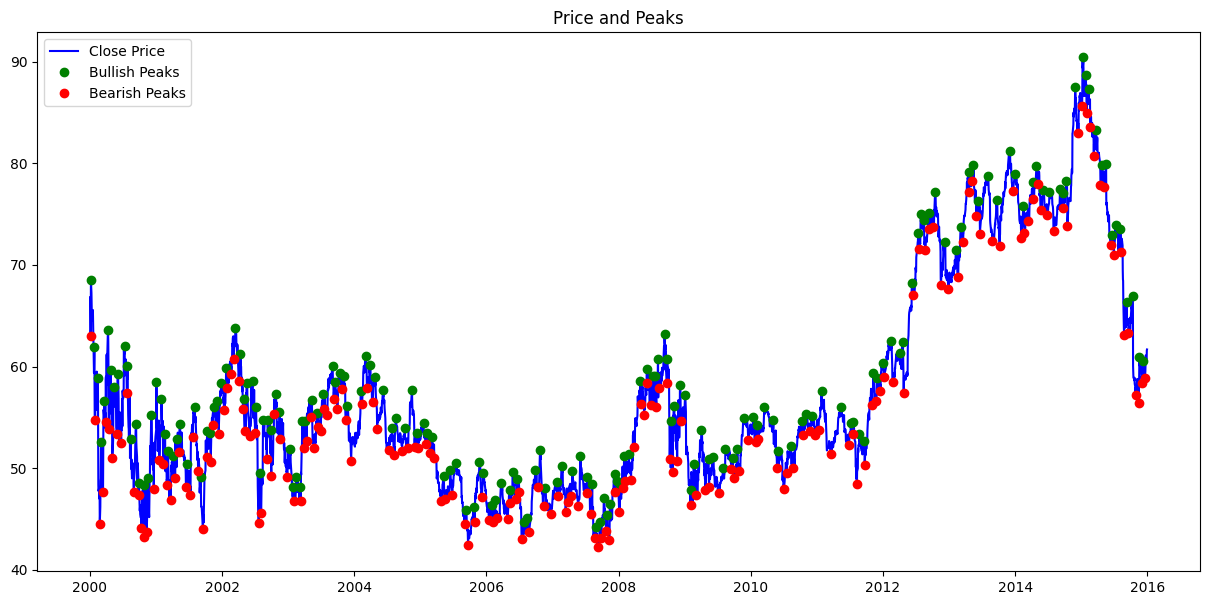

Señales numéricas positivas: 2123
Señales numéricas negativas: 1901
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


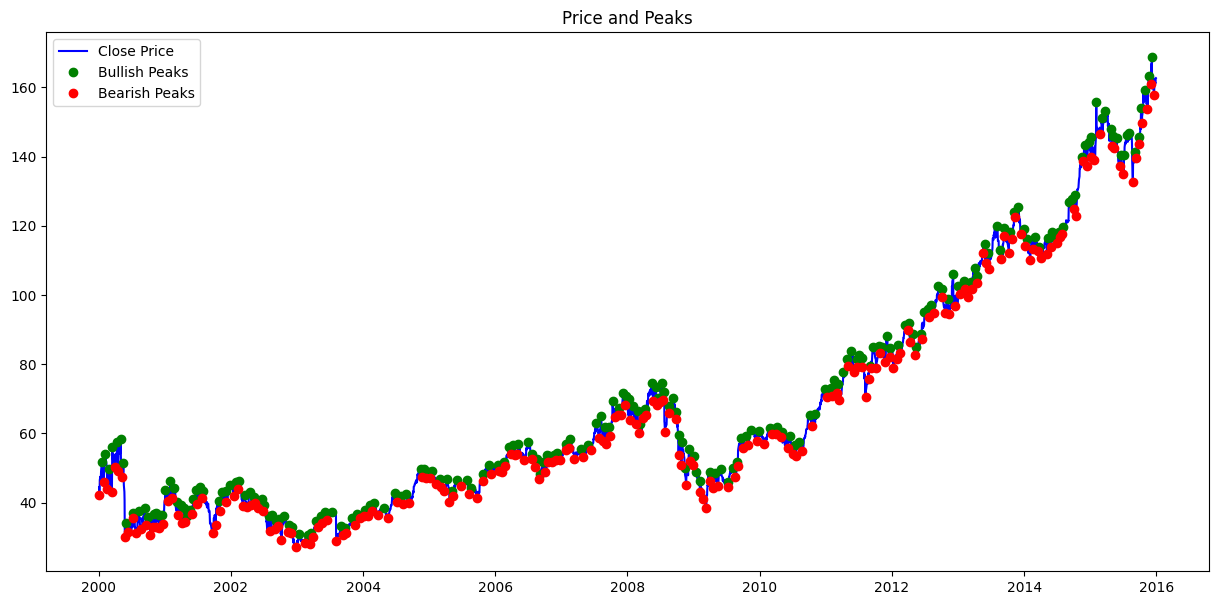

Señales numéricas positivas: 2111
Señales numéricas negativas: 1913
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


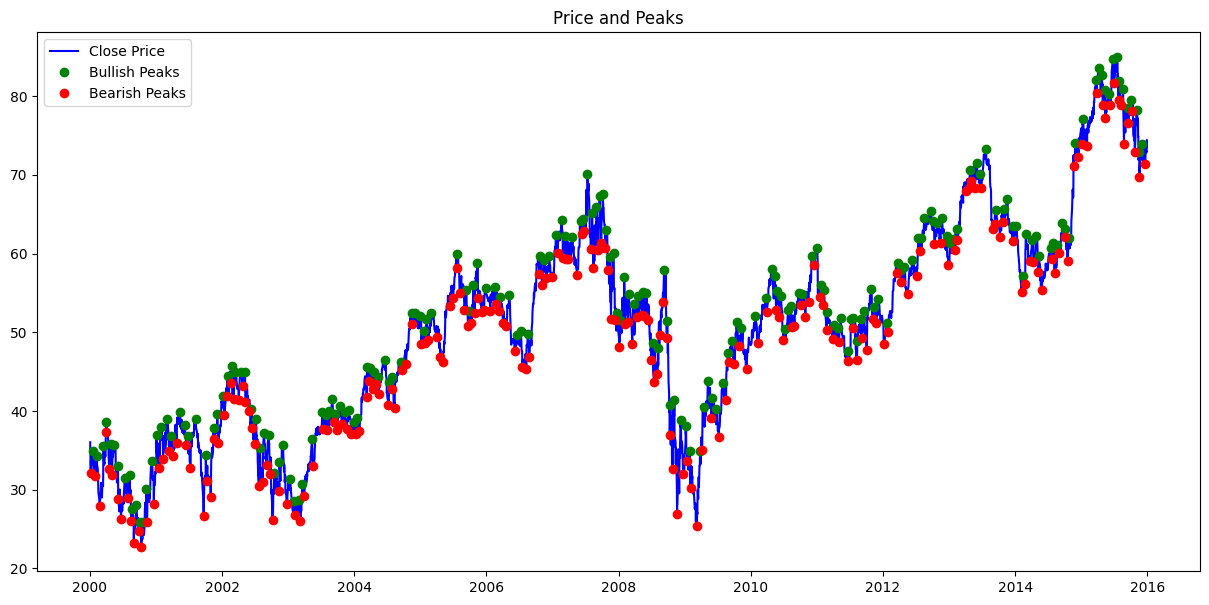

Señales numéricas positivas: 2169
Señales numéricas negativas: 1855
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


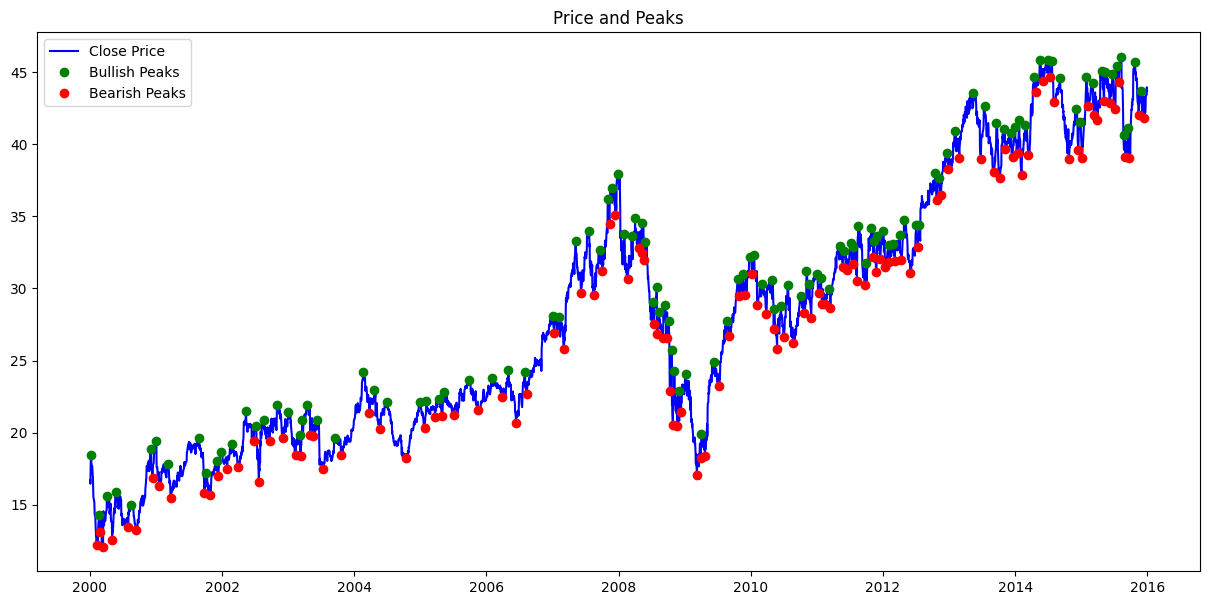

Señales numéricas positivas: 2229
Señales numéricas negativas: 1795
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


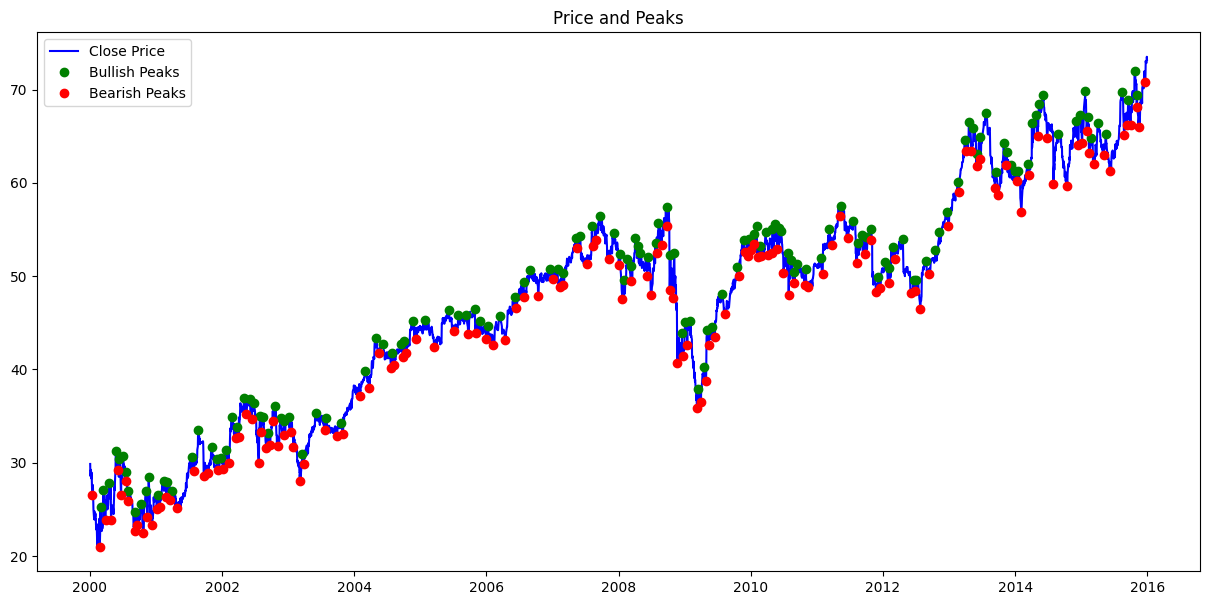

Señales numéricas positivas: 2186
Señales numéricas negativas: 1838
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


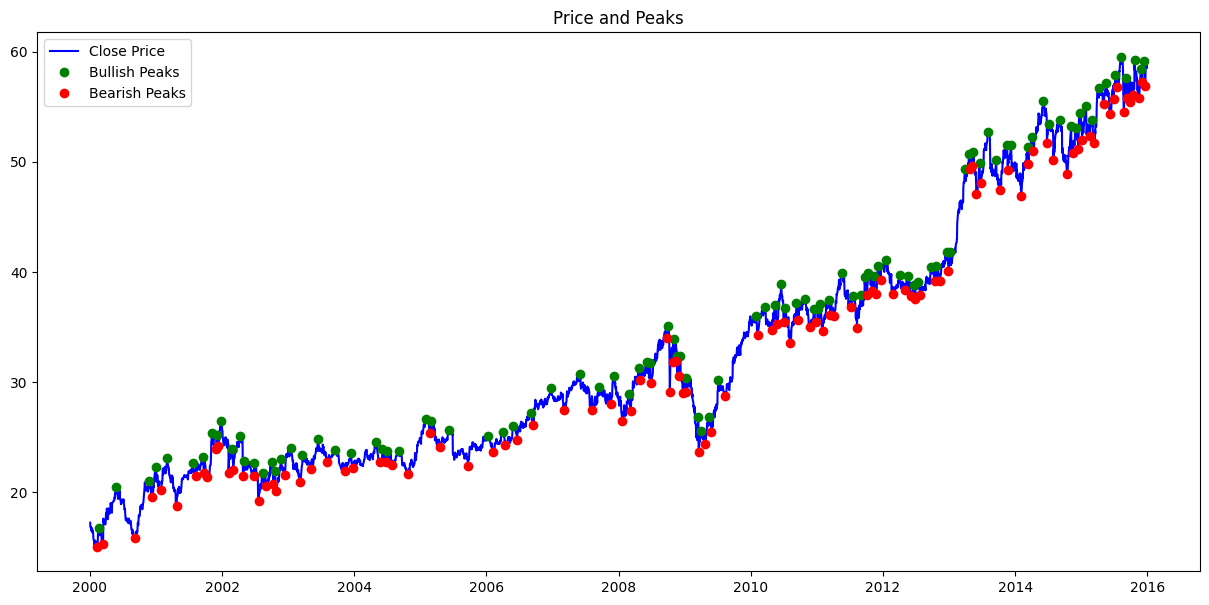

Señales numéricas positivas: 2271
Señales numéricas negativas: 1753
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


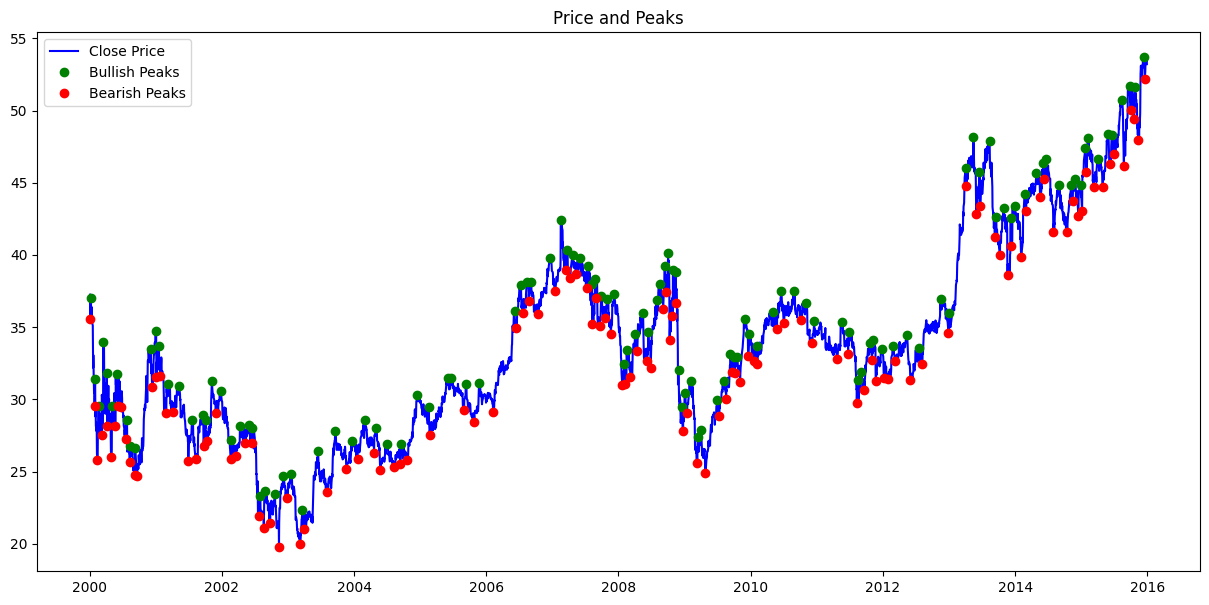

Señales numéricas positivas: 2082
Señales numéricas negativas: 1942
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


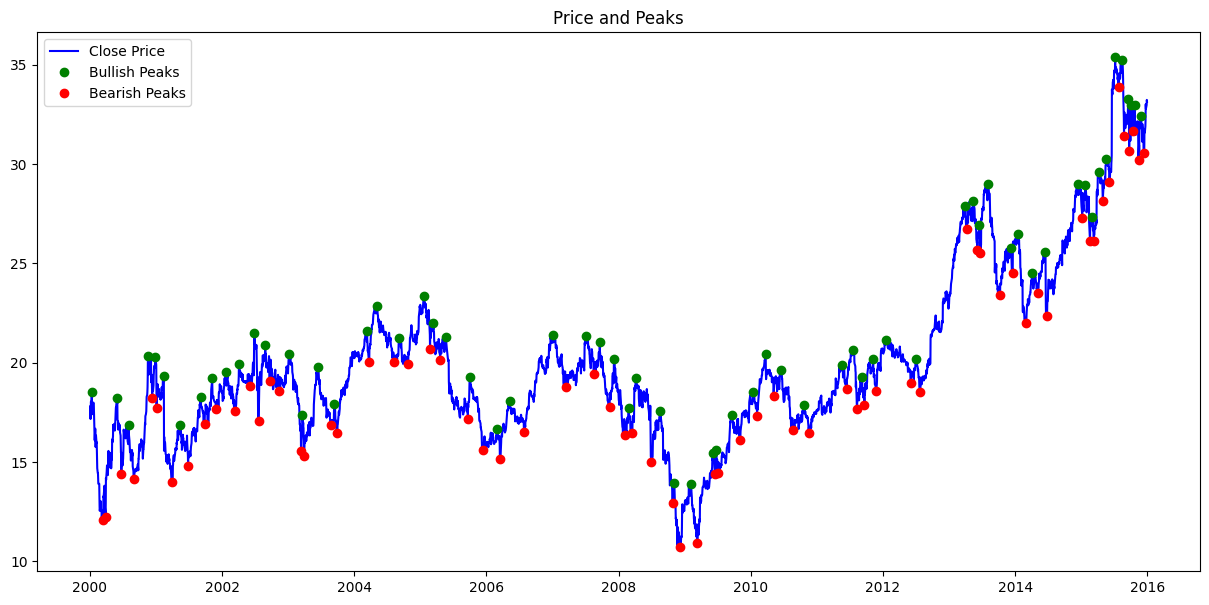

Señales numéricas positivas: 2351
Señales numéricas negativas: 1673
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


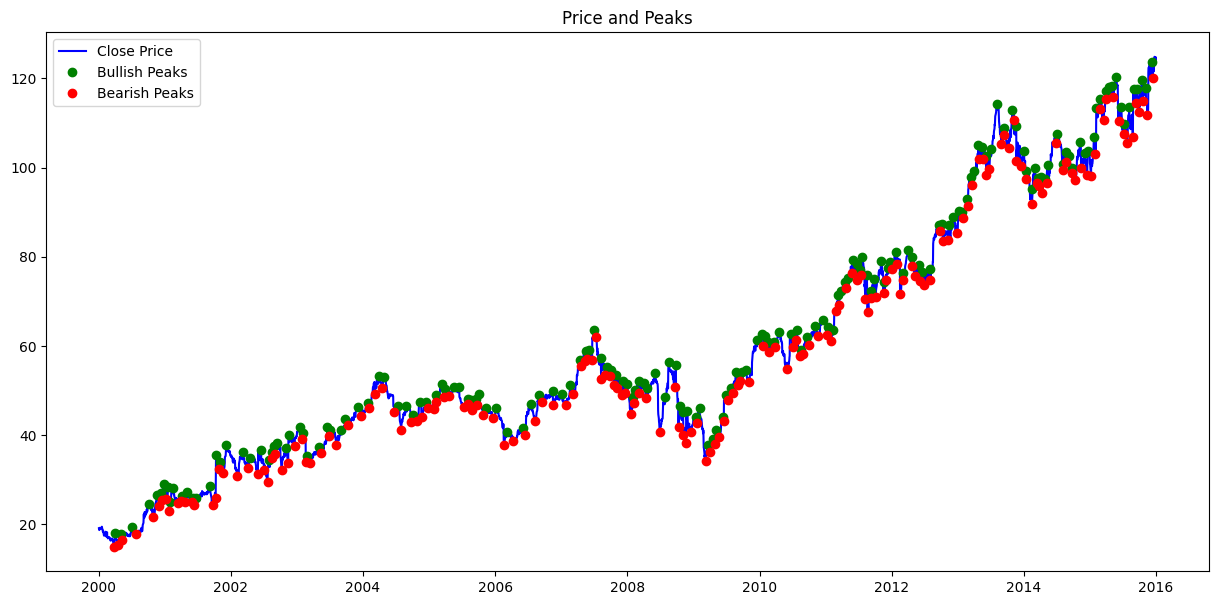

Señales numéricas positivas: 2067
Señales numéricas negativas: 1957
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


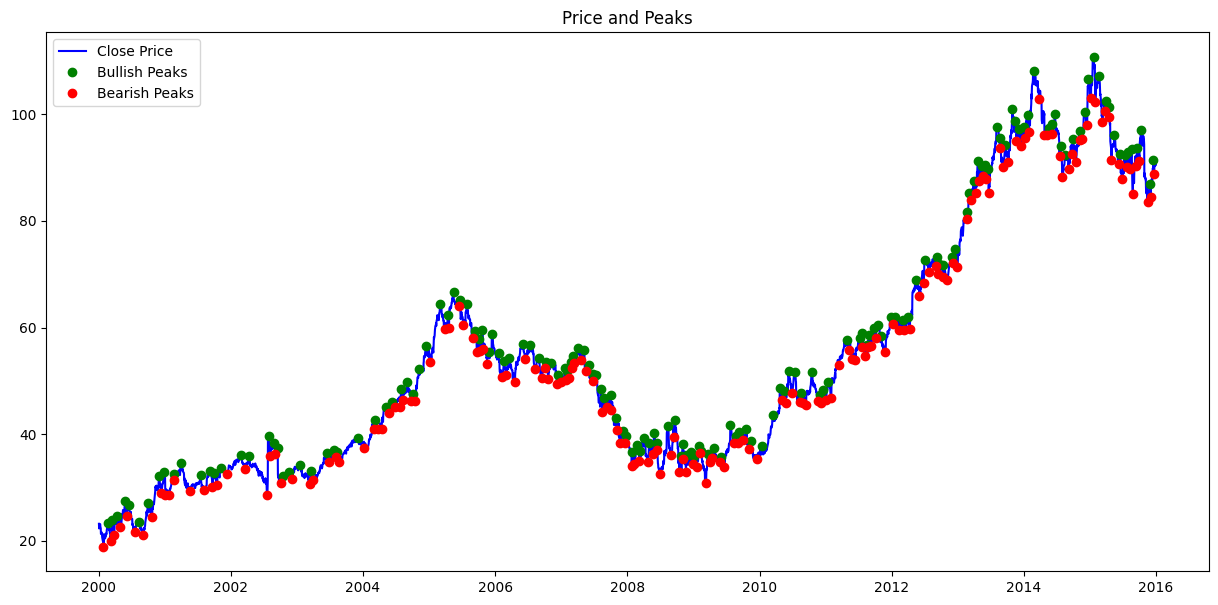

Señales numéricas positivas: 2133
Señales numéricas negativas: 1891
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


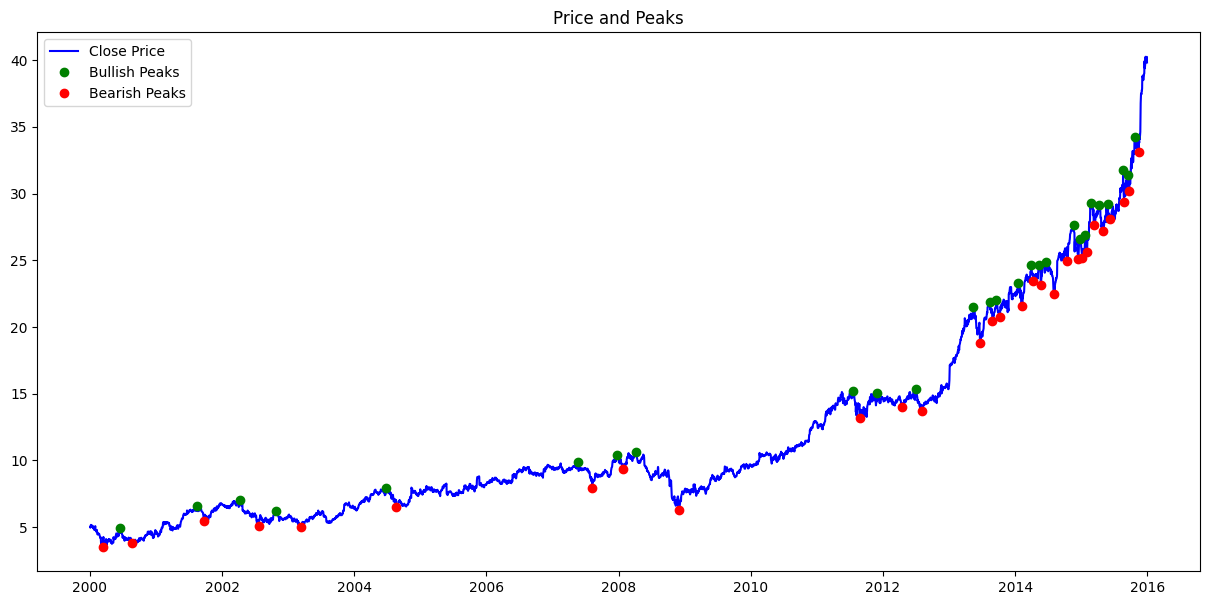

Señales numéricas positivas: 3120
Señales numéricas negativas: 904
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


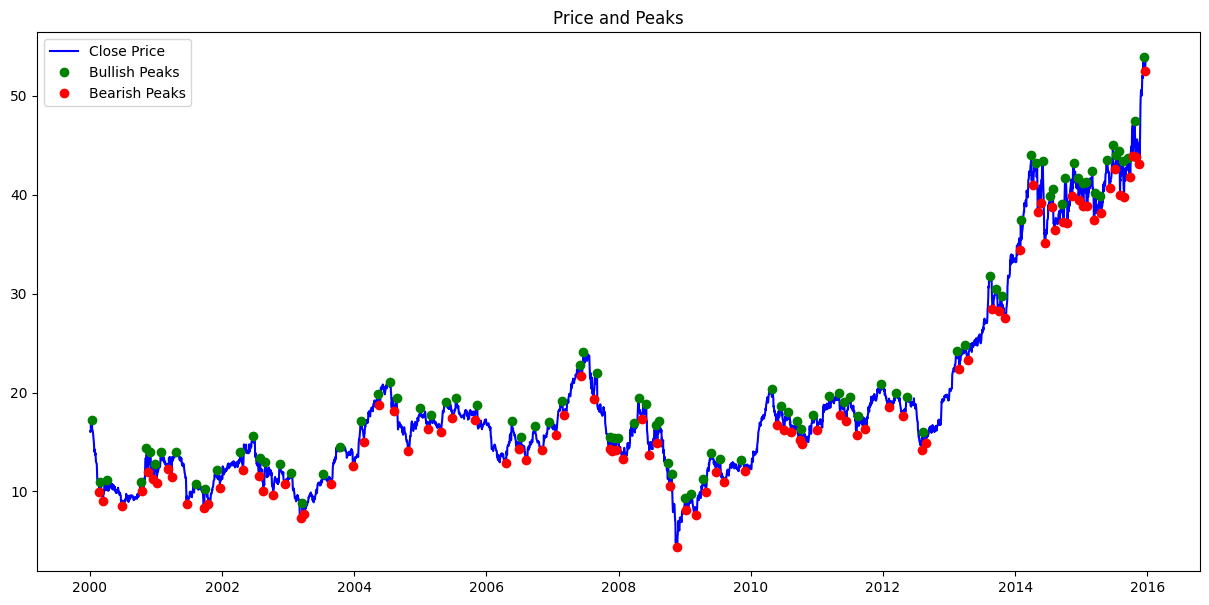

Señales numéricas positivas: 2214
Señales numéricas negativas: 1810
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


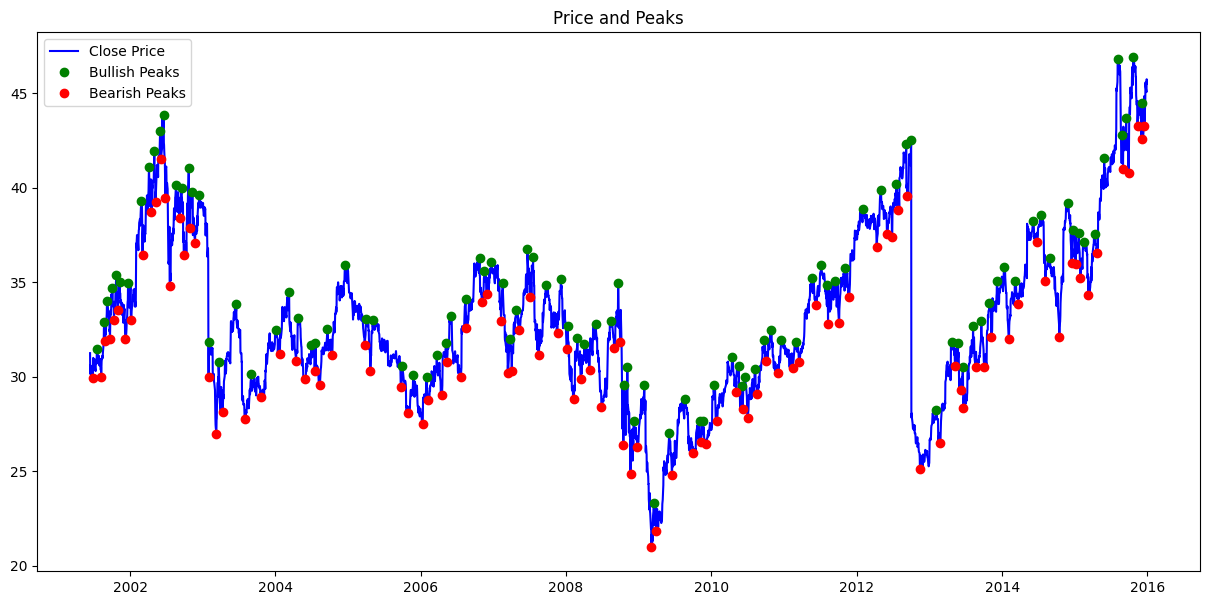

Señales numéricas positivas: 1976
Señales numéricas negativas: 1684
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


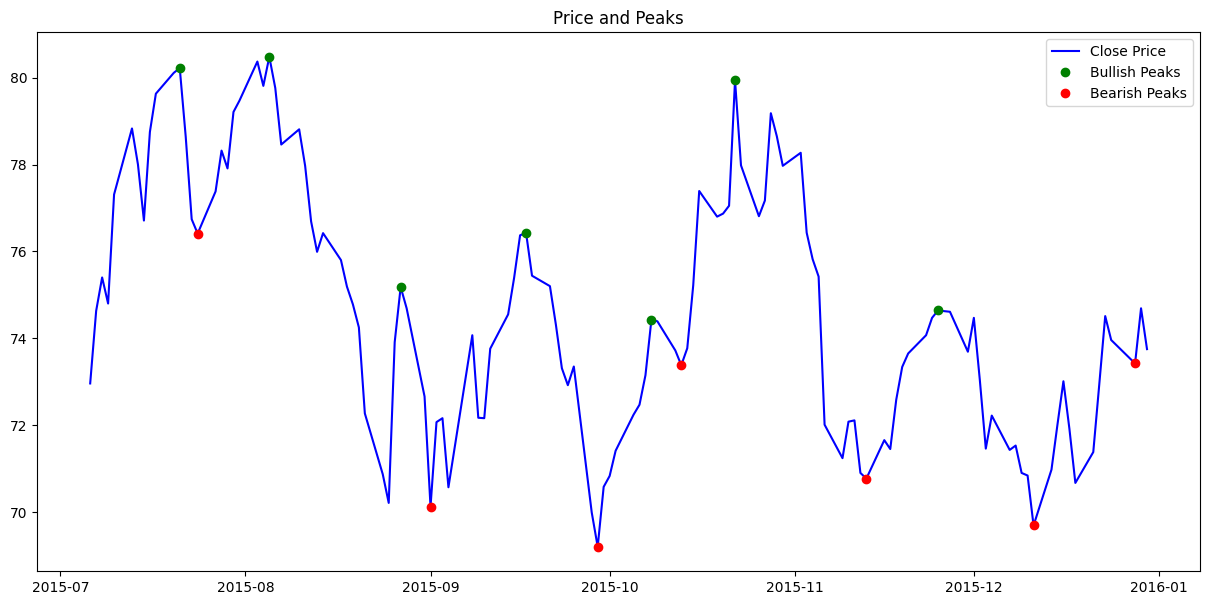

Señales numéricas positivas: 54
Señales numéricas negativas: 71
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


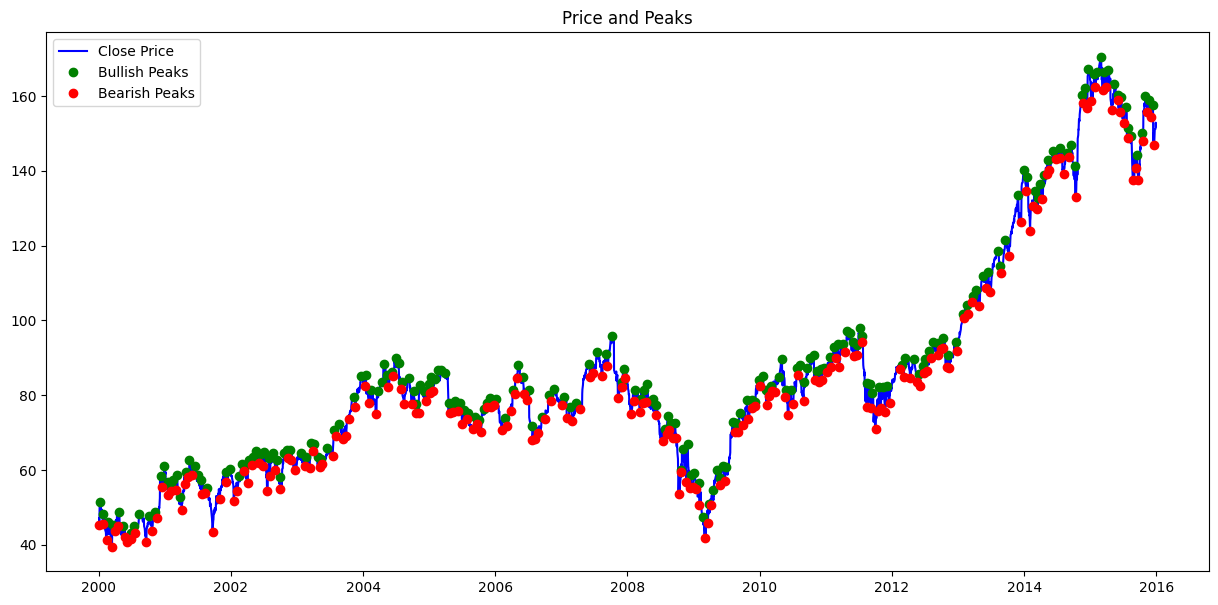

Señales numéricas positivas: 2038
Señales numéricas negativas: 1986
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


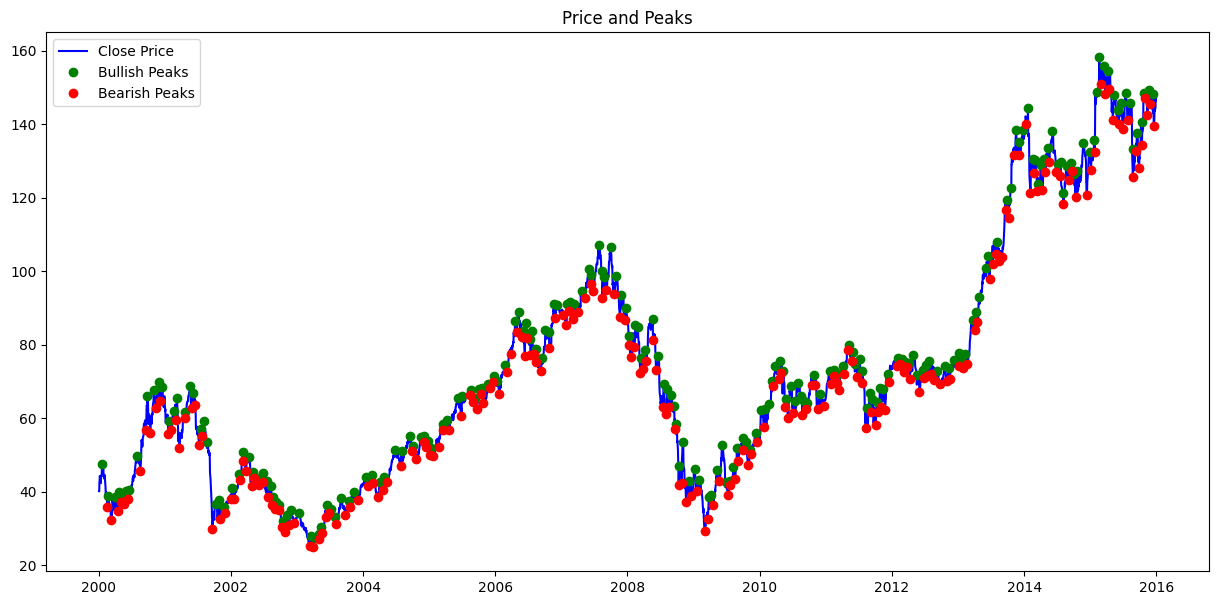

Señales numéricas positivas: 2046
Señales numéricas negativas: 1978
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


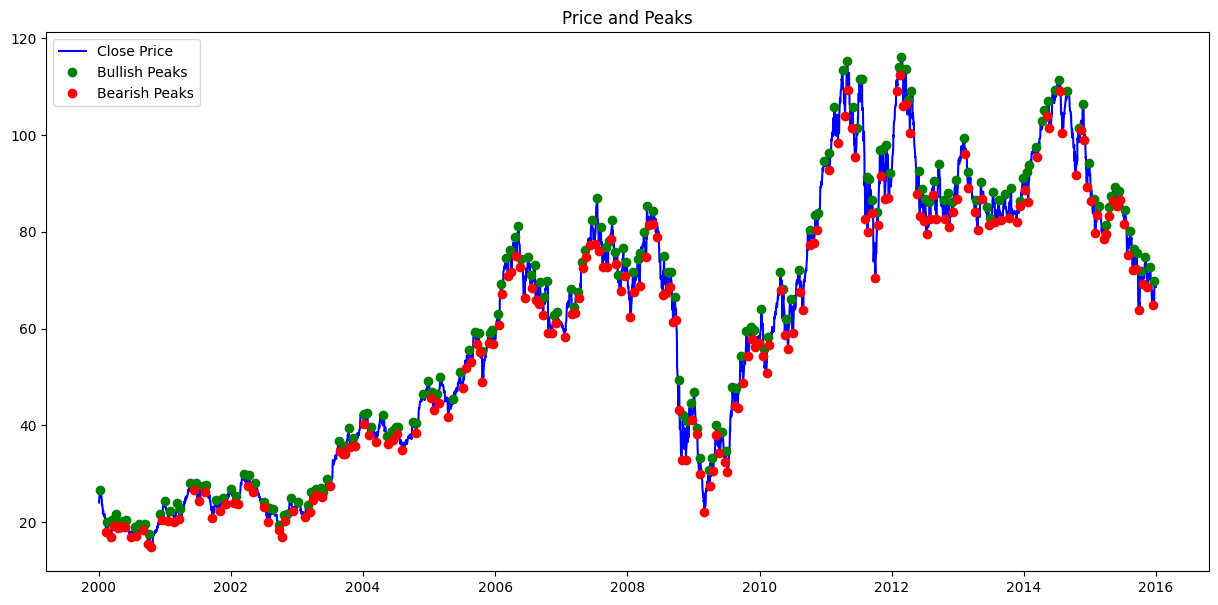

Señales numéricas positivas: 2095
Señales numéricas negativas: 1929
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


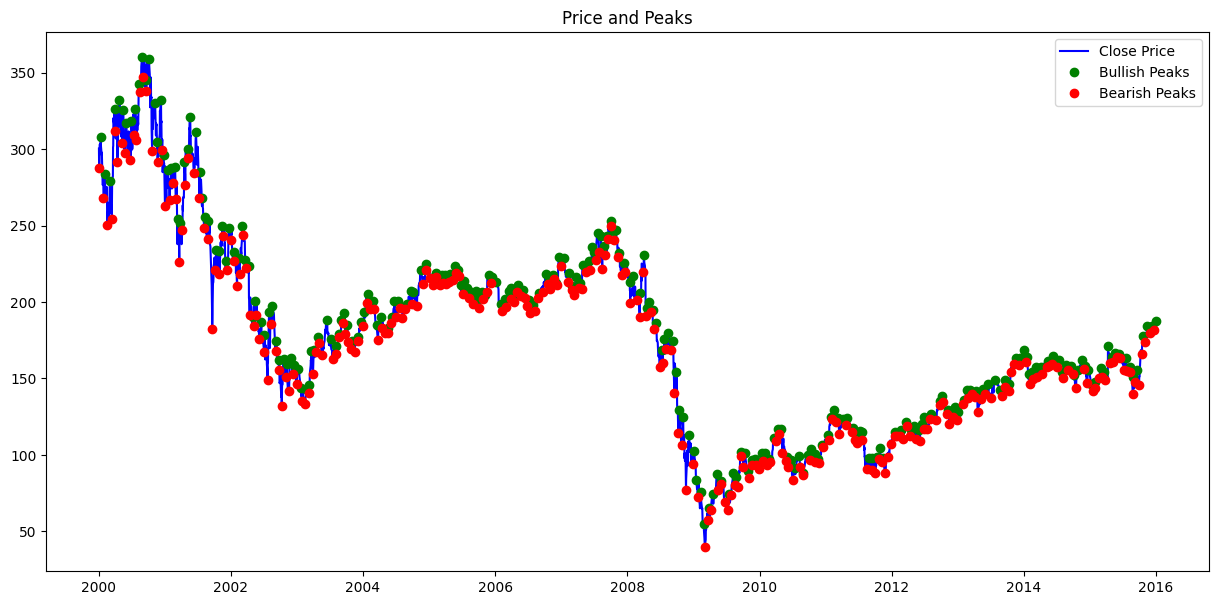

Señales numéricas positivas: 2122
Señales numéricas negativas: 1902
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


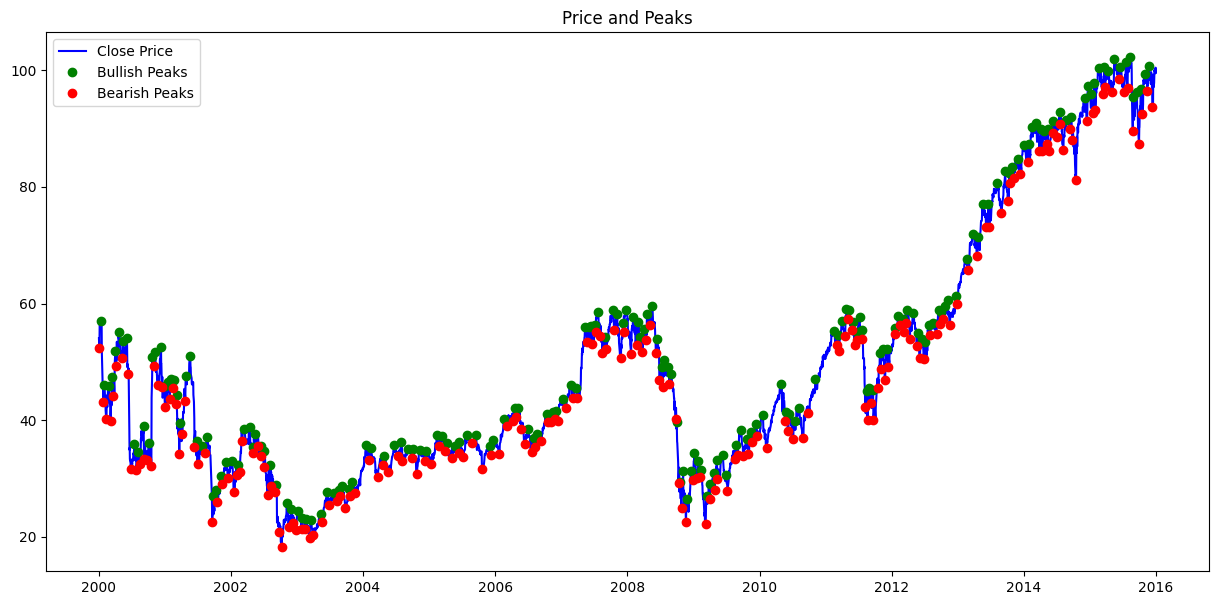

Señales numéricas positivas: 2118
Señales numéricas negativas: 1906
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


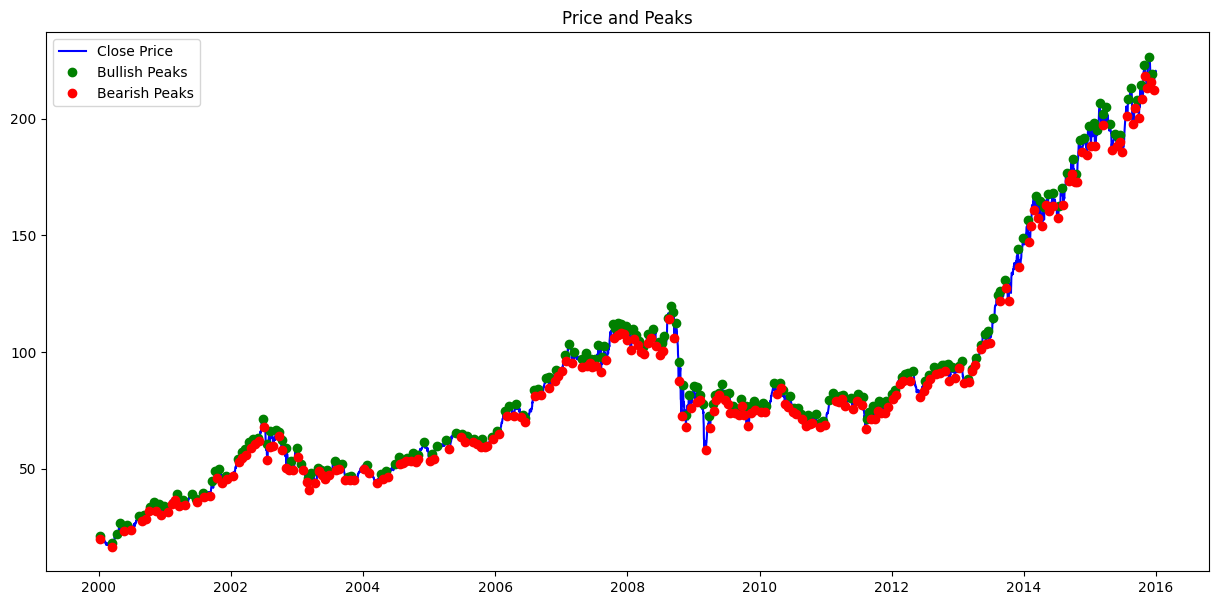

Señales numéricas positivas: 2154
Señales numéricas negativas: 1870
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


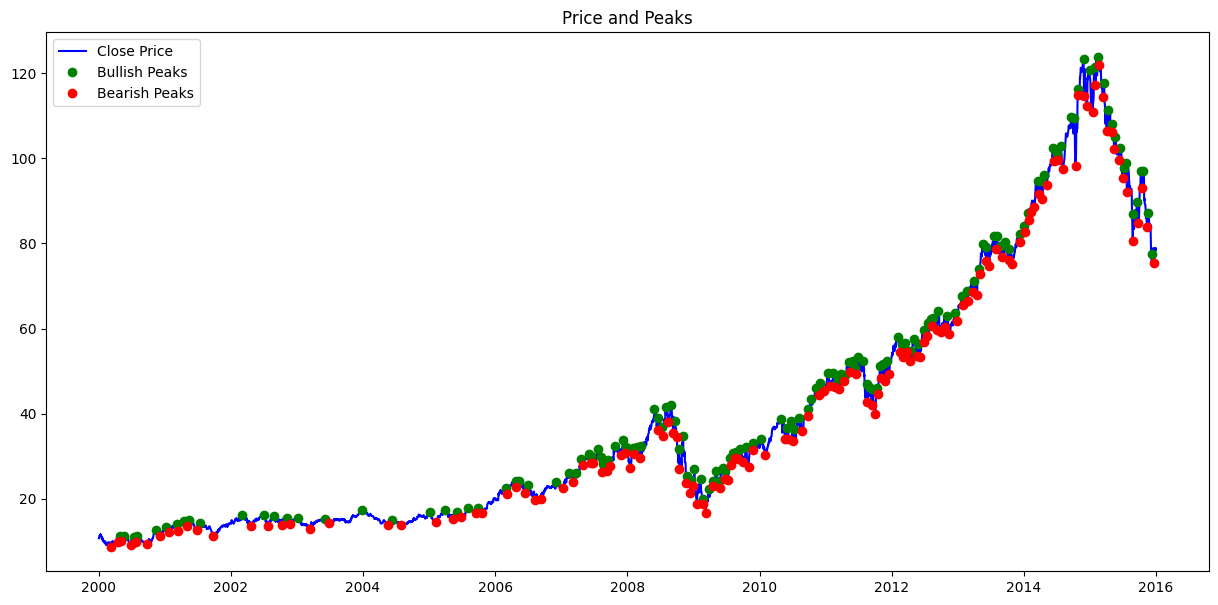

Señales numéricas positivas: 2206
Señales numéricas negativas: 1818
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


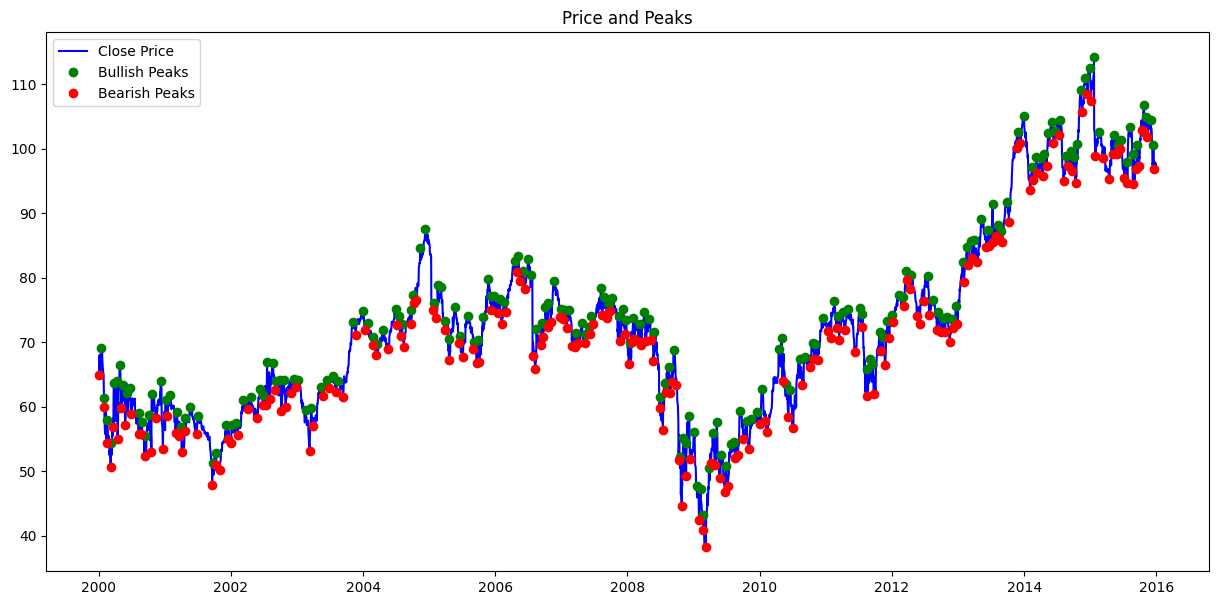

Señales numéricas positivas: 2000
Señales numéricas negativas: 2024
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


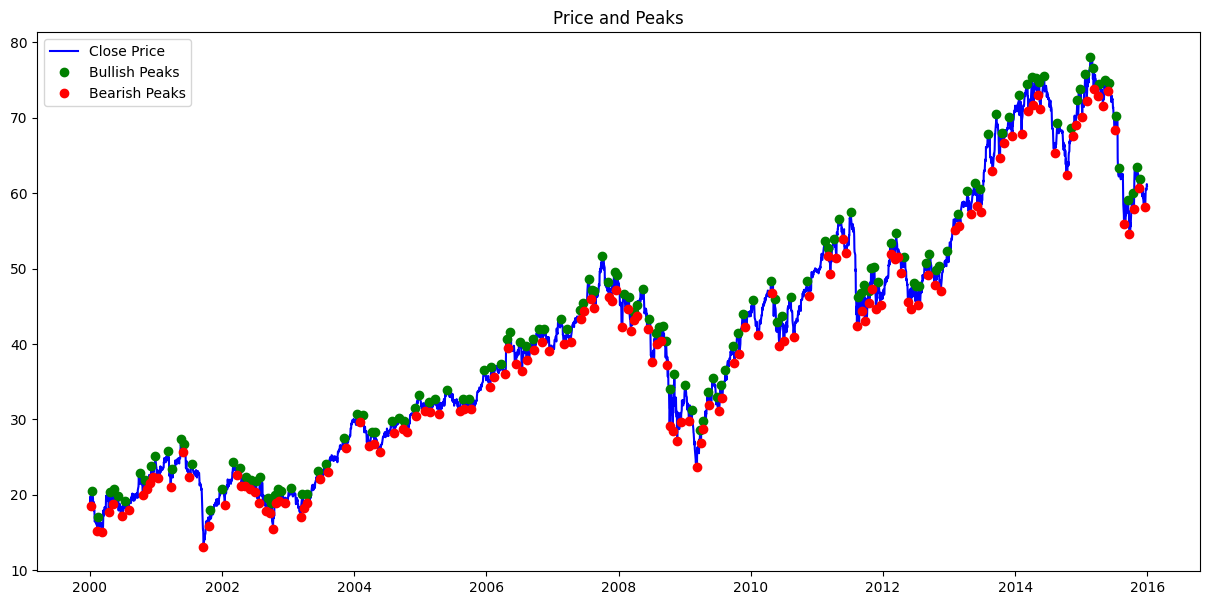

Señales numéricas positivas: 2184
Señales numéricas negativas: 1840
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


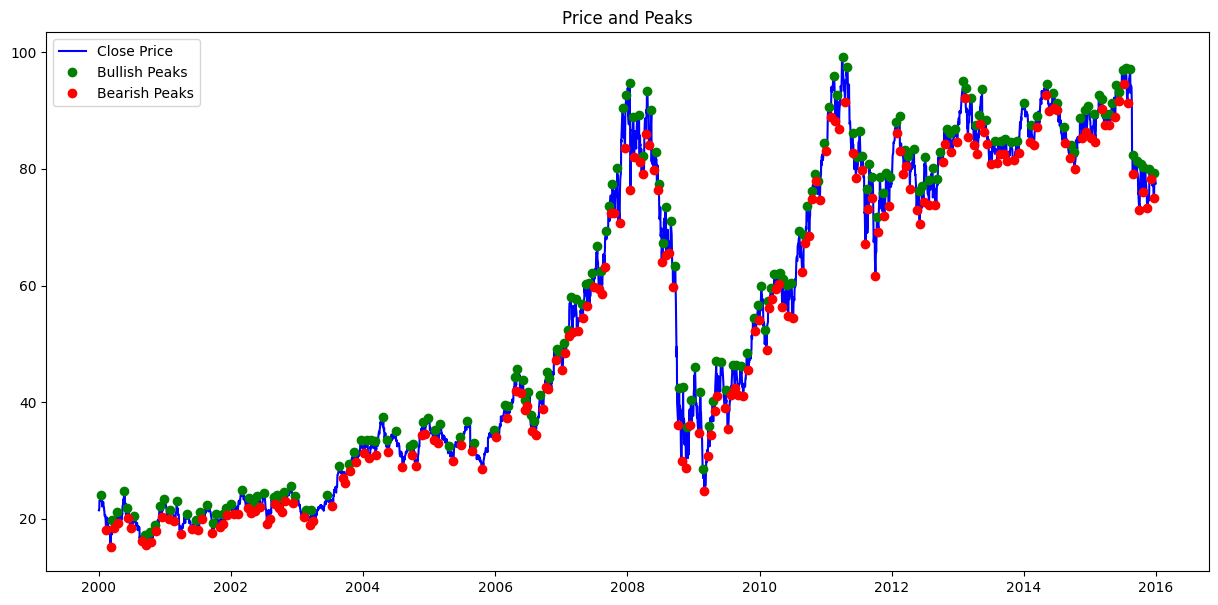

Señales numéricas positivas: 2054
Señales numéricas negativas: 1970
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


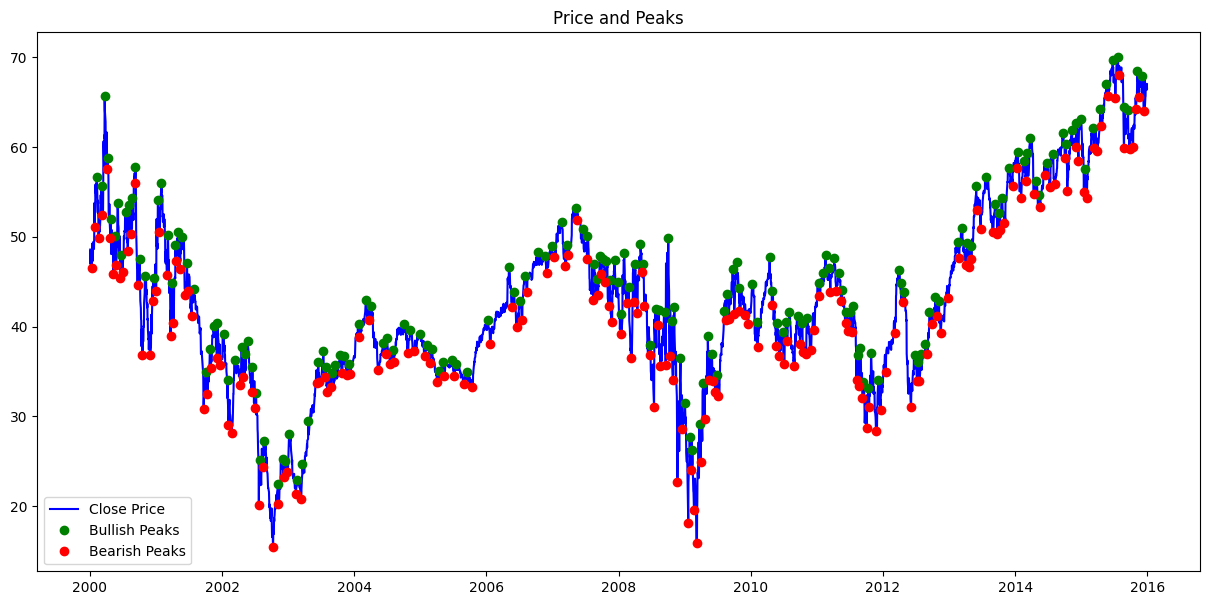

Señales numéricas positivas: 2151
Señales numéricas negativas: 1873
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


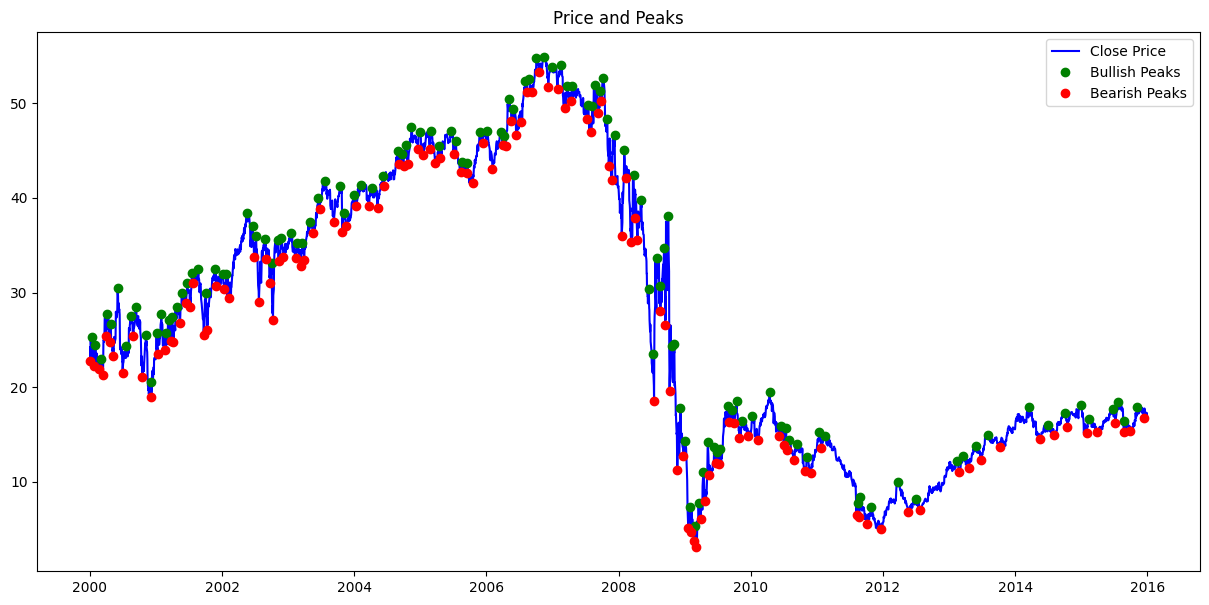

Señales numéricas positivas: 2141
Señales numéricas negativas: 1883
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


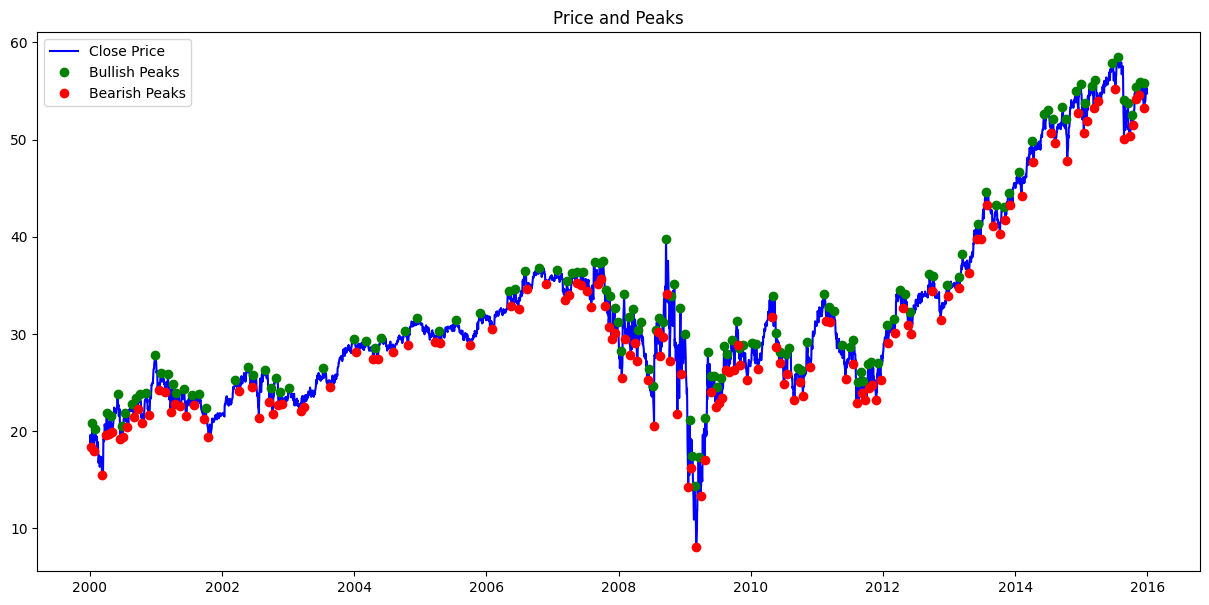

Señales numéricas positivas: 2344
Señales numéricas negativas: 1680
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


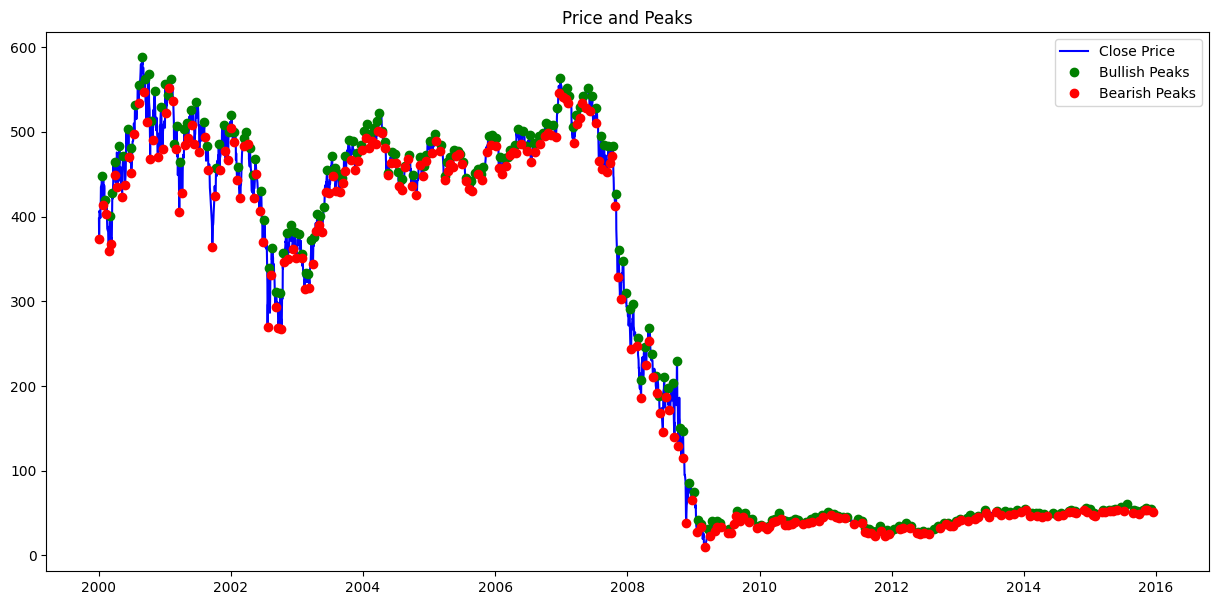

Señales numéricas positivas: 2079
Señales numéricas negativas: 1945
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


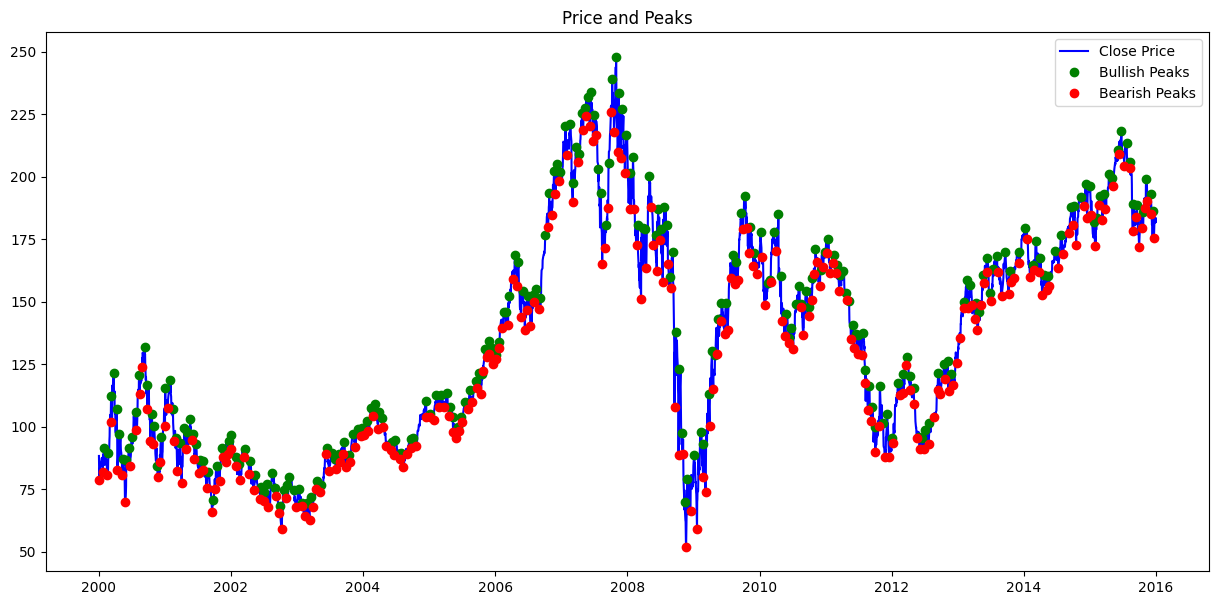

Señales numéricas positivas: 2006
Señales numéricas negativas: 2018
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


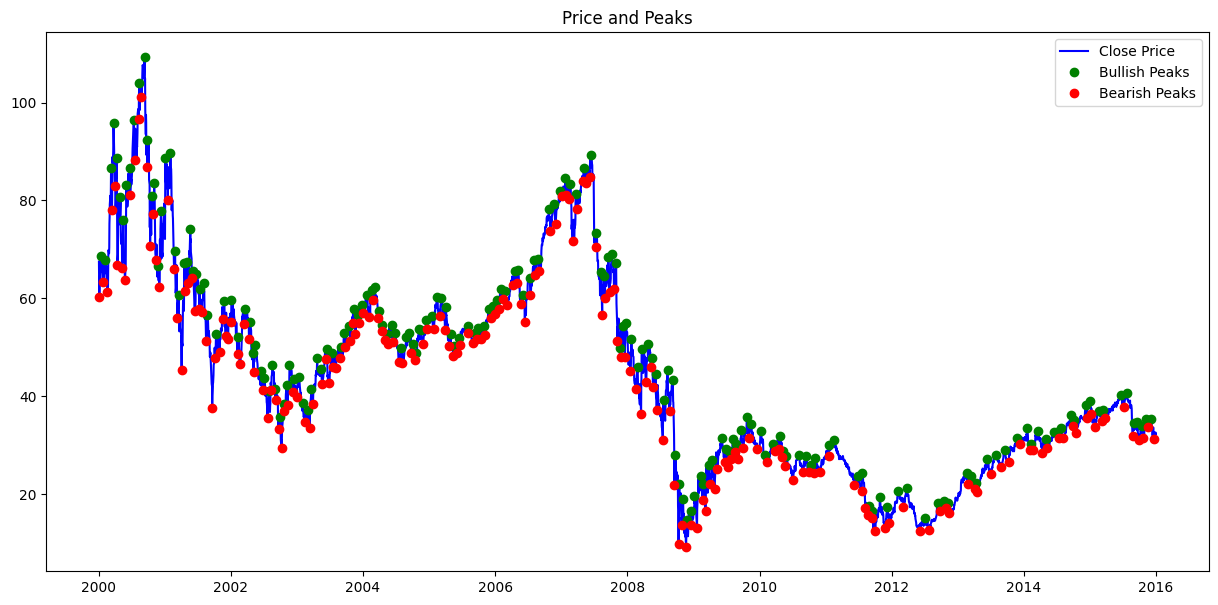

Señales numéricas positivas: 2146
Señales numéricas negativas: 1878
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


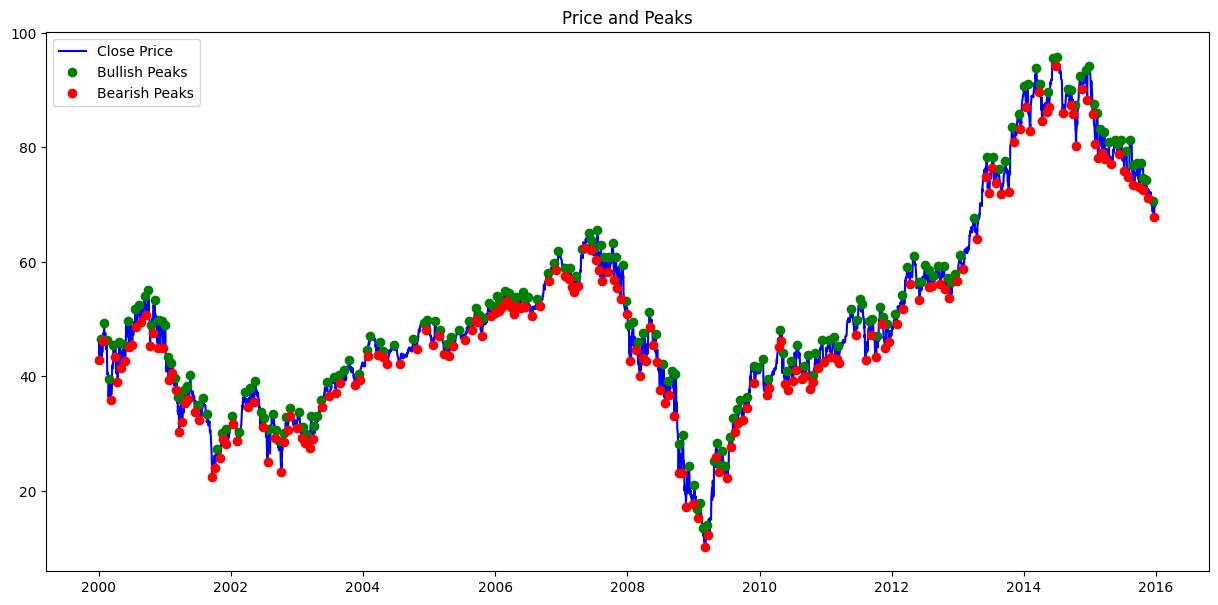

Señales numéricas positivas: 2076
Señales numéricas negativas: 1948
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


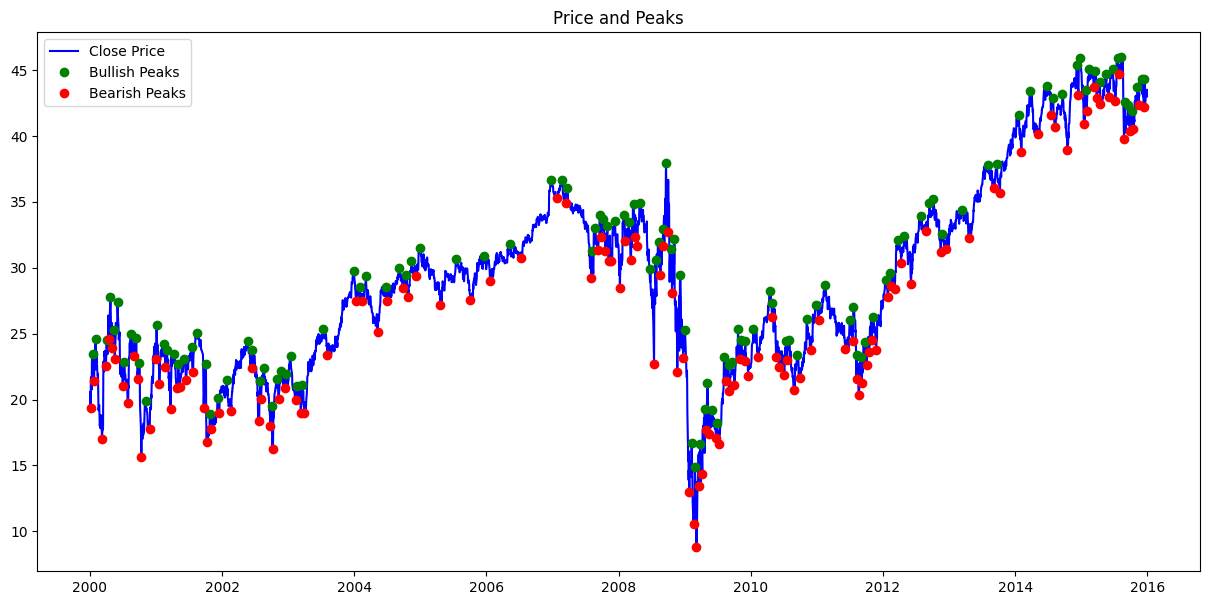

Señales numéricas positivas: 2254
Señales numéricas negativas: 1770
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


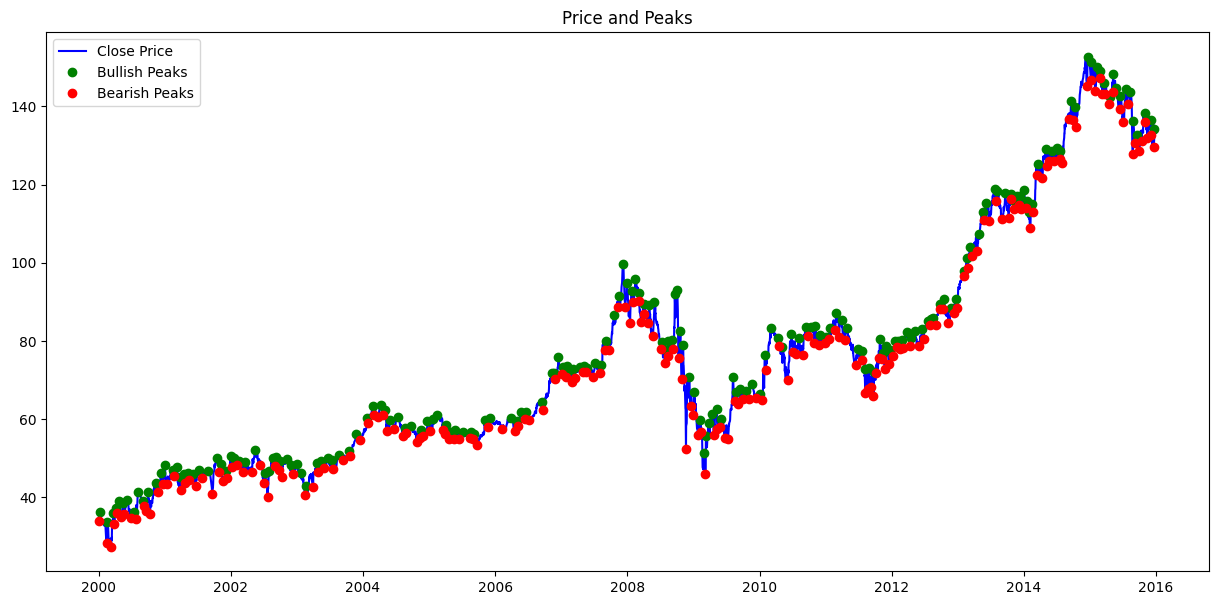

Señales numéricas positivas: 1974
Señales numéricas negativas: 2050
La suma de señales positivas y negativas corresponde con el índice final.
[*********************100%%**********************]  1 of 1 completed


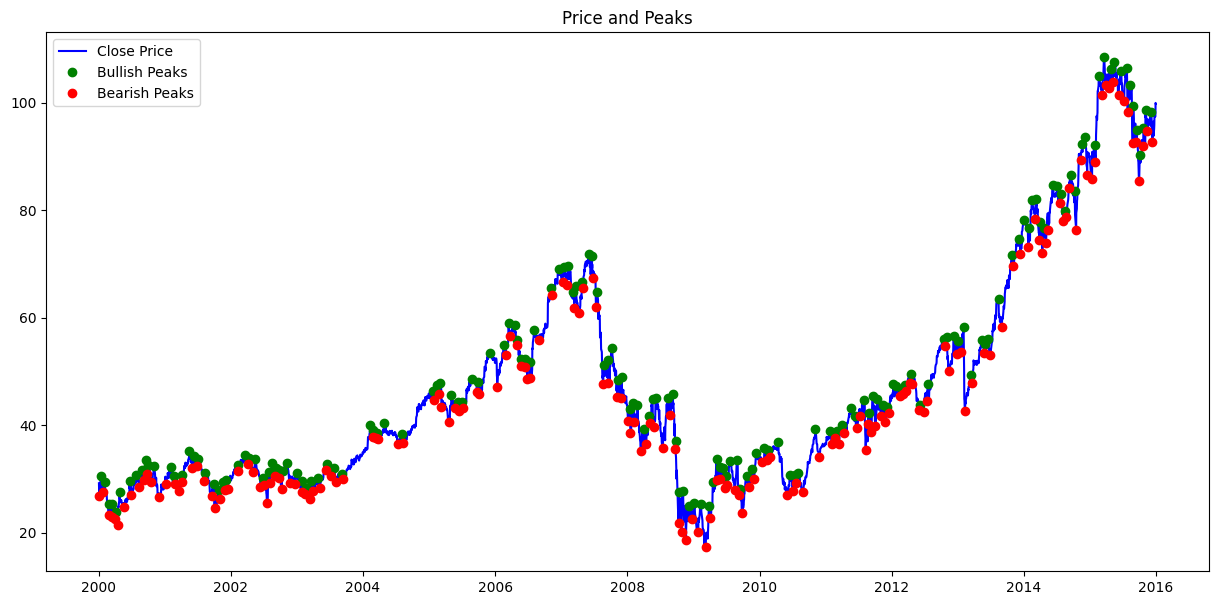

Señales numéricas positivas: 2248
Señales numéricas negativas: 1776
La suma de señales positivas y negativas corresponde con el índice final.


In [ ]:
# Definir una lista ampliada de tickers
tickers_tech = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NFLX", "NVDA", "ORCL", "IBM", "INTC"]
tickers_consumer = ["PEP", "KO", "PG", "MCD", "WMT", "COST", "TGT", "UL"]
tickers_food = ["K", "GIS", "CPB", "CAG", "SJM", "HSY", "HRL", "TSN", "MDLZ", "KHC"]
tickers_industrial = ["MMM", "BA", "CAT", "GE", "HON", "LMT", "UNP", "UPS", "RTX", "DE"]
tickers_financial = ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "USB", "BRK-B", "SPGI"]
all_tickers = tickers_tech + tickers_consumer + tickers_food + tickers_industrial + tickers_financial


# Descargar datos
all_data = {}
for ticker in all_tickers:
    data = yf.download(ticker, start="2000-01-01", end="2015-12-31")
    all_data[ticker] = label_data_for_long_strategy(detect_and_plot_peaks(data))

In [ ]:


# Preprocesamiento
def convert_data_to_sequences(data):
    sequences = []
    labels = []
    for i in range(21, len(data)):
        sequence = data.iloc[i-21:i].apply(lambda x: f"Open: {x['Open']}, High: {x['High']}, Low: {x['Low']}, Close: {x['Close']}, Volume: {x['Volume']}", axis=1).str.cat(sep=' ')
        label = 1 if data.iloc[i]['Trade_Signal'] == 'compra' else 0
        sequences.append(sequence)
        labels.append(label)
    return sequences, labels


# Crear Dataset y DataLoader
class TradingDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.sequences[idx], return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Para guardar checkpoints
checkpoint_dir = "/content/drive/MyDrive/Info de Proyecto BOT/Inteligencia artificial/Compra-venta desde picos"
def normalize_data(data):
    # Asegurarse de que todas las columnas son numéricas
    data = data.apply(pd.to_numeric, errors='coerce')
    return (data - data.min()) / (data.max() - data.min())

# Dividir datos para validación cruzada en el tiempo
def time_series_split(data, train_size=0.8):
    train_length = int(len(data) * train_size)
    return data[:train_length], data[train_length:]


# Métricas de evaluación
def compute_metrics(preds, labels):
    if len(preds.shape) == 2 and preds.shape[1] > 1:
        preds = np.argmax(preds, axis=1)
    elif len(preds.shape) == 1 or preds.shape[1] == 1:
        preds = np.round(preds).astype(int)  # Esto es para un array unidimensional o bidimensional con una sola columna
    precision = precision_score(labels, preds, zero_division=1)
    recall = recall_score(labels, preds, zero_division=1)
    f1 = f1_score(labels, preds, zero_division=1)
    return {'precision': precision, 'recall': recall, 'f1': f1}



In [ ]:

sequences, labels = [], []
for ticker, data in all_data.items():
    s, l = convert_data_to_sequences(data)
    sequences.extend(s)
    labels.extend(l)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dataset = TradingDataset(sequences, labels, tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



# Definir la cantidad de epochs
epochs = 5

# Modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# Entrenamiento y evaluación
results = {}
for ticker, data in all_data.items():
    # Normalizar y dividir datos
    data_normalized = normalize_data(data)
    train_data, val_data = time_series_split(data_normalized)

    # Convertir datos en secuencias y crear Dataloader
    train_sequences, train_labels = convert_data_to_sequences(train_data)
    val_sequences, val_labels = convert_data_to_sequences(val_data)
    train_dataset = TradingDataset(train_sequences, train_labels, tokenizer, max_length=512)
    val_dataset = TradingDataset(val_sequences, val_labels, tokenizer, max_length=512)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

       # Bucle de entrenamiento y evaluación
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Evaluación
        model.eval()
        val_preds = []
        val_labels_list = []
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(batch['label'].cpu().numpy())

                # Imprimir predicciones y etiquetas
                print("Predicciones:", preds.cpu().numpy())
                print("Etiquetas:", labels.cpu().numpy())

        metrics = compute_metrics(val_preds, val_labels_list)
        print(f"Ticker: {ticker} - Epoch {epoch+1}/{epochs} - Validation Metrics: {metrics}")


        # Guardar resultados
        if ticker not in results:
            results[ticker] = []
        results[ticker].append(metrics)

      # Guardar resultados en un archivo JSON
    with open(os.path.join(checkpoint_dir, "results.json"), "w") as f:
          json.dump(results, f)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ticker: AAPL - Epoch 1/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: AAPL - Epoch 2/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: AAPL - Epoch 3/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: AAPL - Epoch 4/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: AAPL - Epoch 5/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: MSFT - Epoch 1/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: MSFT - Epoch 2/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: MSFT - Epoch 3/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: MSFT - Epoch 4/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: MSFT - Epoch 5/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Ticker: GOOGL - Epoch 1/5 - Validation Metrics: {'precision': 1.0, 'recall': 1.0

[*********************100%%**********************]  1 of 1 completed


<ipython-input-4-632eabaf51d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Peak_Type'] = 'None'


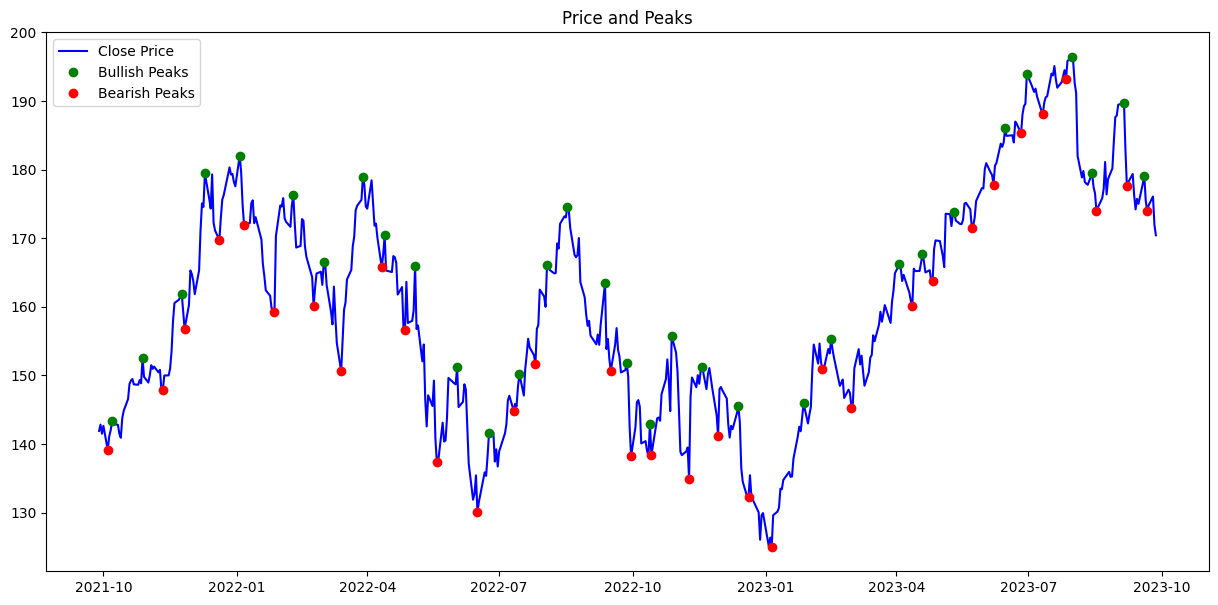

<ipython-input-4-632eabaf51d7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trade_Signal'] = 'None'
<ipython-input-4-632eabaf51d7>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Numeric_Signal'] = 0


Señales numéricas positivas: 271
Señales numéricas negativas: 232
La suma de señales positivas y negativas corresponde con el índice final.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import yfinance as yf
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Descargar datos de acciones
tickers = ["AAPL"]  # Puedes cambiar estos tickers por los que prefieras
data = {ticker: yf.download(ticker, period="2y") for ticker in tickers}

# Seleccionar los últimos 600 días de datos
data = {ticker: df.tail(600) for ticker, df in data.items()}

# Aplicar tus funciones para detectar picos y etiquetar los datos
for ticker, df in data.items():
    df = detect_and_plot_peaks(df)
    df = label_data_for_long_strategy(df)
    data[ticker] = df

# Cargar el modelo
model_path = "/content/drive/MyDrive/Info de Proyecto BOT/Inteligencia artificial/Compra-venta desde picos/model_WMT_epoch_5.pth"
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.load_state_dict(torch.load(model_path))
model.eval()

# Tokenizador
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Convertir los datos en secuencias y cargarlos en un DataLoader
sequences, labels = [], []
for ticker, df in data.items():
    s, l = convert_data_to_sequences(df)
    sequences.extend(s)
    labels.extend(l)

test_dataset = TradingDataset(sequences, labels, tokenizer, max_length=512)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Realizar predicciones
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Aquí puedes comparar las predicciones con las etiquetas reales
# ...


Correct one day before: 140
One day delay or advance: 140
Correct on change day: 140
One day delay or advance on change: 139
Precision: 0.5008298755186722
Recall: 1.0
F1 Score: 0.6674039259054465


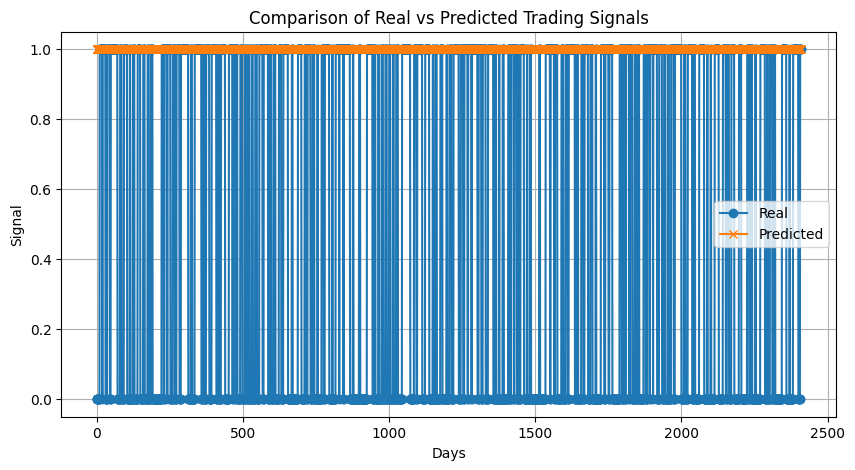

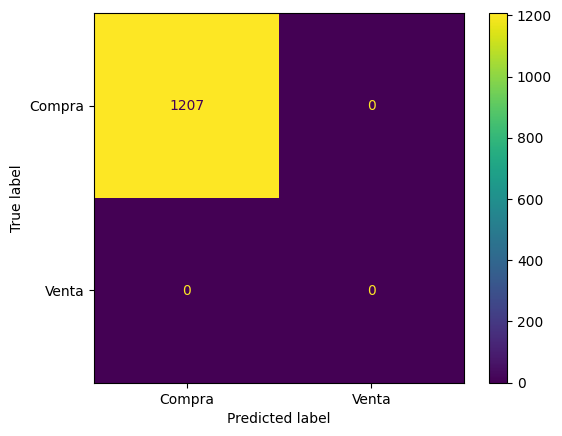

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Asumiendo que 'labels' contiene las etiquetas reales y 'predictions' las predicciones del modelo
# Ambas listas deben estar ordenadas cronológicamente

# Inicializar contadores
correct_one_day_before = 0
one_day_delay_or_advance = 0
correct_on_change_day = 0
one_day_delay_or_advance_on_change = 0

# Iterar sobre las etiquetas y predicciones
for i in range(1, len(labels) - 1):  # Empezamos desde 1 para evitar un índice negativo
    # Verificar la predicción un día antes
    if labels[i] != labels[i - 1] and predictions[i - 1] == labels[i]:
        correct_one_day_before += 1

    # Verificar un día de adelanto o atraso
    if labels[i] != labels[i - 1] and (predictions[i + 1] == labels[i] or predictions[i - 2] == labels[i]):
        one_day_delay_or_advance += 1

    # Verificar la predicción en el día del cambio
    if labels[i] != labels[i - 1] and predictions[i] == labels[i]:
        correct_on_change_day += 1

    # Verificar un día de adelanto o atraso en el día del cambio
    if labels[i] != labels[i - 1] and (predictions[i + 1] == labels[i - 1] or predictions[i - 2] == labels[i - 1]):
        one_day_delay_or_advance_on_change += 1

# Imprimir resultados
print(f"Correct one day before: {correct_one_day_before}")
print(f"One day delay or advance: {one_day_delay_or_advance}")
print(f"Correct on change day: {correct_on_change_day}")
print(f"One day delay or advance on change: {one_day_delay_or_advance_on_change}")

# Calcular precisión, recall y F1-score
metrics = compute_metrics(np.array(predictions), np.array(labels))
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1 Score: {metrics['f1']}")

# Graficar las predicciones
plt.figure(figsize=(10,5))
plt.plot(labels, label='Real', marker='o')
plt.plot(predictions, label='Predicted', marker='x')
plt.xlabel('Days')
plt.ylabel('Signal')
plt.title('Comparison of Real vs Predicted Trading Signals')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar la matriz de confusión
cm = confusion_matrix(labels, predictions, labels=[1, -1])  # 1 para compra, -1 para venta
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Compra', 'Venta'])
disp.plot()
plt.show()
